In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from math import sqrt

import env
import acquire
import prepare
import model

import explore
import evaluate

import warnings
warnings.filterwarnings("ignore")

import sklearn as sk
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import SelectKBest, f_regression, RFE
from sklearn.metrics import mean_squared_error

# Acquire

The function shown below is contained in the acquire module and obtains the approriate data as a dataframe from the Codeup SQL database, then caches it for later use as a local.csv

In [2]:
# import os
# import pandas as pd
# import env

# def zillow_2017_data():
    
#     filename = 'zillow.csv'
    
#     if os.path.exists(filename):
#         print('Reading from local CSV...')
#         return pd.read_csv(filename)
    
#     url = env.get_db_url('zillow')
#     sql = '''
#             SELECT bedroomcnt, 
#                    bathroomcnt, 
#                    calculatedfinishedsquarefeet, 
#                    taxvaluedollarcnt, 
#                    yearbuilt, 
#                    taxamount,
#                    fips 
#               FROM properties_2017
#                 LEFT JOIN propertylandusetype USING (propertylandusetypeid)
#               WHERE propertylandusedesc IN ("Single Family Residential", 
#                                             "Inferred Single Family Residential")
#                   AND parcelid IN (
#                                    SELECT properties_2017.parcelid
#                                      FROM properties_2017
#                                        JOIN predictions_2017 USING(parcelid)
#                                      WHERE transactiondate LIKE "2017%%"
#                                   );
#             '''
    
#     print('No local file exists\nReading from SQL database...')
#     df = pd.read_sql(sql, url)

#     print('Saving to local CSV... ')
#     df.to_csv(filename, index=False)
    
#     return df

In [3]:
df = acquire.zillow_2017_data()

Reading from local CSV...


In [4]:
df.head().fips.unique()

array([6111., 6037., 6059.])

# Preparation

An initial look at our data

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52441 entries, 0 to 52440
Data columns (total 9 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   bedroomcnt                    52441 non-null  float64
 1   bathroomcnt                   52441 non-null  float64
 2   calculatedfinishedsquarefeet  52359 non-null  float64
 3   taxvaluedollarcnt             52440 non-null  float64
 4   yearbuilt                     52325 non-null  float64
 5   fips                          52441 non-null  float64
 6   garagetotalsqft               18015 non-null  float64
 7   poolcnt                       11096 non-null  float64
 8   lotsizesquarefeet             52072 non-null  float64
dtypes: float64(9)
memory usage: 3.6 MB


In [6]:
df.describe()

,bedroomcnt,bathroomcnt,calculatedfinishedsquarefeet,taxvaluedollarcnt,yearbuilt,fips,garagetotalsqft,poolcnt,lotsizesquarefeet
count,52441.000000,52441.000000,52359.000000,5.244000e+04,52325.000000,52441.000000,18015.000000,11096.0,5.207200e+04
mean,3.300681,2.299403,1922.890754,5.296882e+05,1963.393884,6049.132149,495.875715,1.0,1.133962e+04
std,0.949094,1.022772,1004.365838,7.518946e+05,23.133571,21.029067,157.044712,0.0,8.674763e+04
min,0.000000,0.000000,128.000000,1.000000e+03,1878.000000,6037.000000,0.000000,1.0,2.360000e+02
25%,3.000000,2.000000,1268.000000,1.937475e+05,1950.000000,6037.000000,426.000000,1.0,5.583000e+03
50%,3.000000,2.000000,1659.000000,3.736120e+05,1961.000000,6037.000000,462.000000,1.0,6.840500e+03
75%,4.000000,3.000000,2306.000000,6.193012e+05,1979.000000,6059.000000,567.000000,1.0,8.798250e+03
max,14.000000,18.000000,21929.000000,4.906124e+07,2016.000000,6111.000000,4251.000000,1.0,6.971010e+06


In [7]:
df.head()

,bedroomcnt,bathroomcnt,calculatedfinishedsquarefeet,taxvaluedollarcnt,yearbuilt,fips,garagetotalsqft,poolcnt,lotsizesquarefeet
0,3.0,3.0,1738.0,458000.0,1999.0,6111.0,422.0,NaN,3305.0
1,4.0,3.0,2754.0,557671.0,2001.0,6111.0,592.0,1.0,19916.0
2,3.0,2.0,1827.0,97506.0,1964.0,6037.0,NaN,NaN,7360.0
3,3.0,2.5,1404.0,342037.0,1973.0,6059.0,420.0,NaN,2012.0
4,2.0,1.0,866.0,34631.0,1954.0,6059.0,NaN,NaN,6042.0


In [8]:
df.isnull().sum()

bedroomcnt                          0
bathroomcnt                         0
calculatedfinishedsquarefeet       82
taxvaluedollarcnt                   1
yearbuilt                         116
fips                                0
garagetotalsqft                 34426
poolcnt                         41345
lotsizesquarefeet                 369
dtype: int64

In [9]:
# replace null values for garagetotalsqft and poolcnt with 0
df['garagetotalsqft'] = np.where(df.garagetotalsqft.isna(), 0, df.garagetotalsqft)
df['poolcnt'] = np.where(df.poolcnt.isna(), 0, df.poolcnt)

In [10]:
df.isnull().sum()

bedroomcnt                        0
bathroomcnt                       0
calculatedfinishedsquarefeet     82
taxvaluedollarcnt                 1
yearbuilt                       116
fips                              0
garagetotalsqft                   0
poolcnt                           0
lotsizesquarefeet               369
dtype: int64

In [11]:
df.isnull().sum().sum() / len(df)

0.010831219847066227

Since null values represent a very small fraction (at most, about 0.4%) of the total number of values, we will drop all rows containing null values now. We do not expect this to have a significant effect on analysis or modeling due to the small amount of data lost. 

In [12]:
orig_len = len(df)
df = df.dropna()

In [13]:
orig_len - len(df)

482

In [14]:
124 / len(df)

0.002386497045747609

By dropping rows with null values, we only lost about 0.2% of observations, confirming that this should have no significant affect on the overall data. 

In [15]:
df.fips.unique()

array([6111., 6037., 6059.])

In [16]:
# renaming columns for readability
df = df.rename(columns = {'bedroomcnt': 'bedrooms',
                          'bathroomcnt': 'bathrooms', 
                          'calculatedfinishedsquarefeet': 'sqft', 
                          'taxvaluedollarcnt': 'tax_value',
                          'yearbuilt': 'year_built',
                          'taxamount': 'tax_amount'})

In [17]:
# changing data types

# changing year from float to int
df['year_built'] = df.year_built.apply(lambda year: int(year))
# adding a feature: age 
df['age'] = 2017 - df.year_built
# drop original year_built_column
df = df.drop(columns='year_built')

# changing fips codes to strings
df['fips'] = df.fips.apply(lambda fips: '0' + str(int(fips)))

**Split the data** into train, test, and validate samples

In [18]:
train, test, validate = prepare.train_test_validate_split(df)

train	 n = 29096
test	 n = 10392
validate n = 12471


In [19]:
#df = prepare.prep_zillow_1(df)

# Exploration

**Univariate Exploration:** Examining the distributions of our target and each of our features

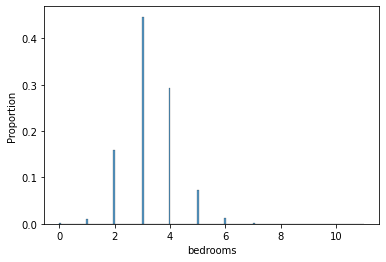

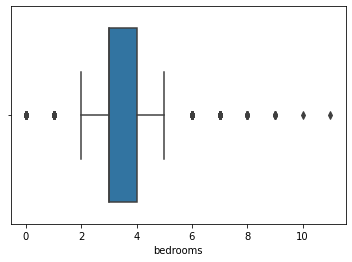

           bedrooms
count  29096.000000
mean       3.304337
std        0.935157
min        0.000000
25%        3.000000
50%        3.000000
75%        4.000000
max       11.000000


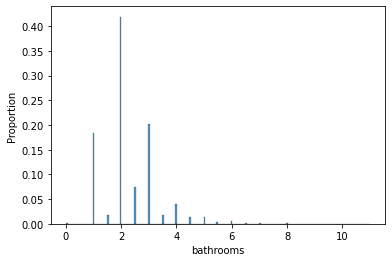

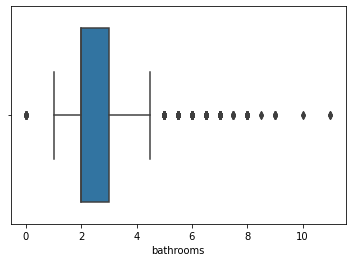

          bathrooms
count  29096.000000
mean       2.294456
std        1.015399
min        0.000000
25%        2.000000
50%        2.000000
75%        3.000000
max       11.000000


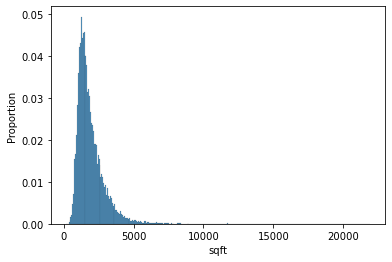

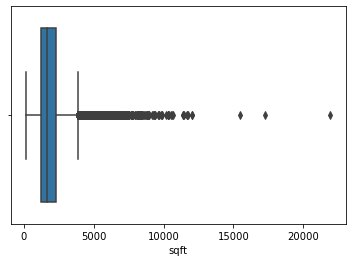

               sqft
count  29096.000000
mean    1919.186177
std     1006.216869
min      152.000000
25%     1264.000000
50%     1652.000000
75%     2297.000000
max    21929.000000


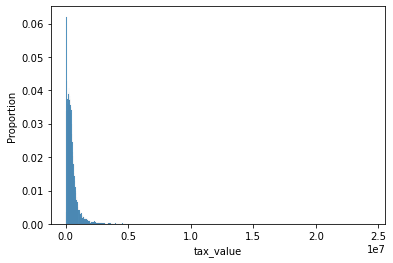

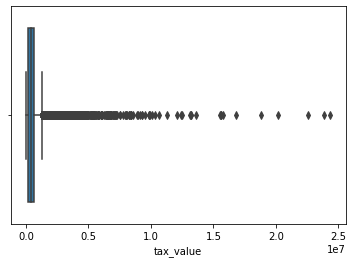

          tax_value
count  2.909600e+04
mean   5.290248e+05
std    7.509414e+05
min    1.000000e+03
25%    1.931812e+05
50%    3.713625e+05
75%    6.150675e+05
max    2.434570e+07


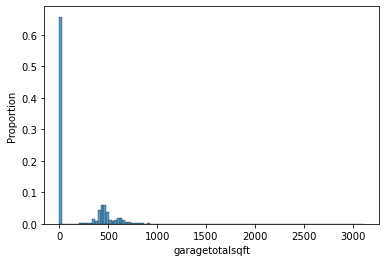

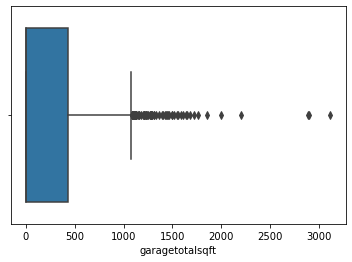

       garagetotalsqft
count     29096.000000
mean        172.256118
std         253.288117
min           0.000000
25%           0.000000
50%           0.000000
75%         433.000000
max        3115.000000


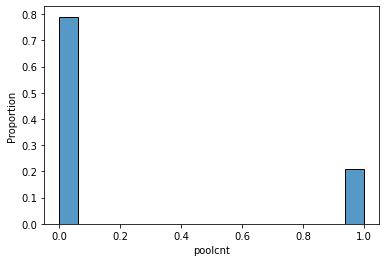

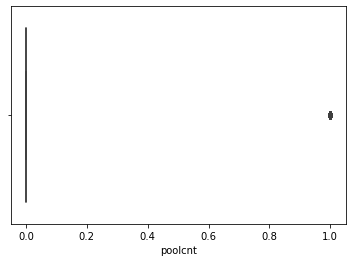

            poolcnt
count  29096.000000
mean       0.209891
std        0.407238
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        1.000000


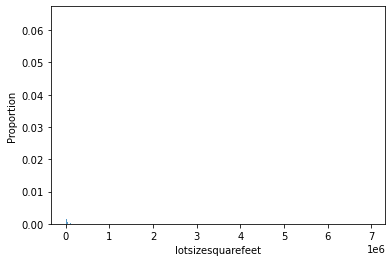

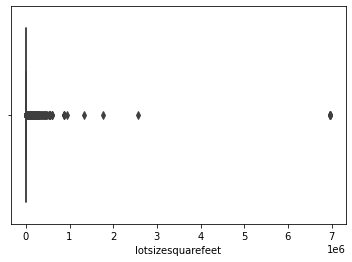

       lotsizesquarefeet
count       2.909600e+04
mean        1.163239e+04
std         1.042592e+05
min         4.800000e+02
25%         5.562000e+03
50%         6.825000e+03
75%         8.759000e+03
max         6.971010e+06


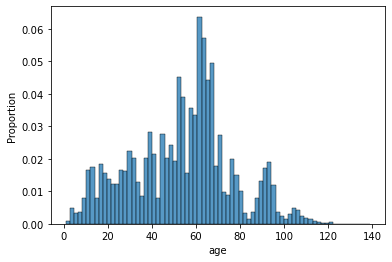

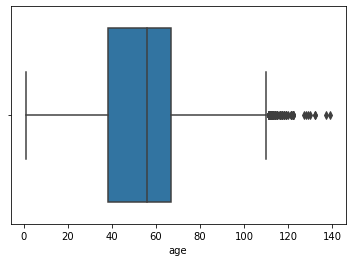

                age
count  29096.000000
mean      53.803581
std       22.986454
min        1.000000
25%       38.000000
50%       56.000000
75%       67.000000
max      139.000000


In [20]:
# define quantitative columns
quantitative_columns = [col for col in train.columns if train[col].dtype != 'object']

# for each of those columns:
for col in quantitative_columns:

        # display a histogram of that column's distribution
        sns.histplot(train[col], stat='proportion')
        plt.show()

        # display a boxplot of that column's distribution
        sns.boxplot(train[col])
        plt.show()

        # display the summary statistics of the distribution
        print(pd.DataFrame(train[col].describe()))

**Handling Outliers** It is evident in the visualizations shown above that these distributions contain significant outliers in the categories of age, sqft, bedrooms, bathrooms, and tax value. 

Our model will generalize better if it is focused on the typical (i.e. median) homes. Further, we expect that markets for luxury homes and historical homes are significantly different than the general home market, and that an altogether different model would likely be necessary for those categories. 

We will therefore drop observations that contain such outliers. 



In [21]:
train.fips.unique()

array(['06037', '06059', '06111'], dtype=object)

In [22]:
def remove_outliers(train, validate, test, k, col_list):

    # Create a column that will label our rows as containing an outlier value or not
    train['outlier'] = False
    validate['outlier'] = False
    test['outlier'] = False
    for col in col_list:

        q1, q3 = train[col].quantile([.25, .75])  # get quartiles
        
        iqr = q3 - q1   # calculate interquartile range
        
        upper_bound = q3 + k * iqr   # get upper bound
        lower_bound = q1 - k * iqr   # get lower bound

        # update the outlier label any time that the value is outside of boundaries
        train['outlier'] = np.where(((train[col] < lower_bound) | (train[col] > upper_bound)) & (train.outlier == False), True, train.outlier)
        validate['outlier'] = np.where(((validate[col] < lower_bound) | (validate[col] > upper_bound)) & (validate.outlier == False), True, validate.outlier)
        test['outlier'] = np.where(((test[col] < lower_bound) | (test[col] > upper_bound)) & (test.outlier == False), True, test.outlier)

    # remove observations with the outlier label in each of the three samples
    train = train[train.outlier == False]
    train = train.drop(columns=['outlier'])

    validate = validate[validate.outlier == False]
    validate = validate.drop(columns=['outlier'])

    test = test[test.outlier == False]
    test = test.drop(columns=['outlier'])

    # print the remaining 
    print(f'train\t n = {train.shape[0]}')
    print(f'test\t n = {test.shape[0]}')
    print(f'validate n = {validate.shape[0]}')

    return train, validate, test

train, validate, test = remove_outliers(train, validate, test, 1.5, 
                                        ['bedrooms', 'bathrooms',
                                         'sqft', 'age', 'tax_value'])

train	 n = 25902
test	 n = 9256
validate n = 11089


**explore univarate again:**

While the distributions remain skewed, we have removed most observations that fall outside of what might be considered a normal range. 

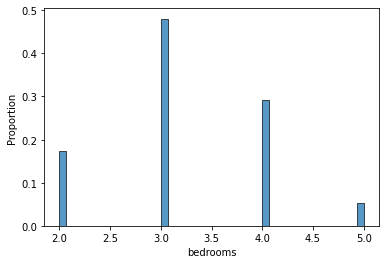

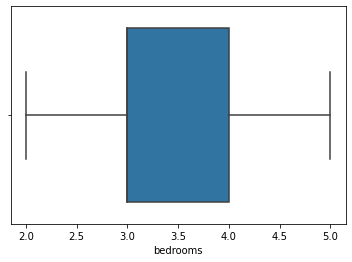

           bedrooms
count  25902.000000
mean       3.226855
std        0.792883
min        2.000000
25%        3.000000
50%        3.000000
75%        4.000000
max        5.000000


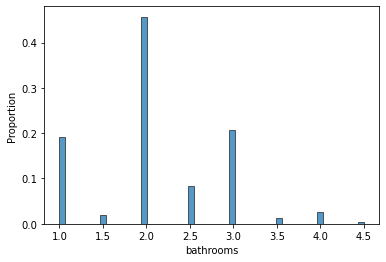

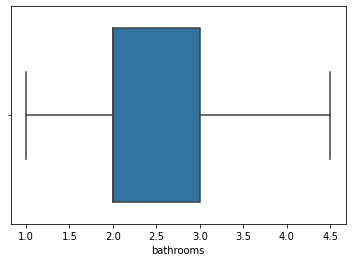

          bathrooms
count  25902.000000
mean       2.130299
std        0.754323
min        1.000000
25%        2.000000
50%        2.000000
75%        3.000000
max        4.500000


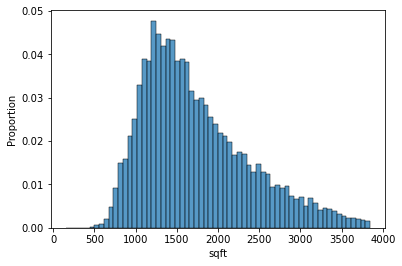

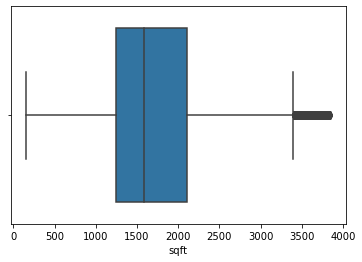

               sqft
count  25902.000000
mean    1734.282063
std      648.638044
min      152.000000
25%     1246.000000
50%     1590.000000
75%     2107.000000
max     3846.000000


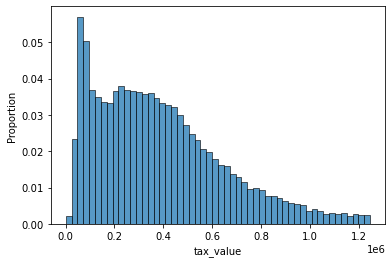

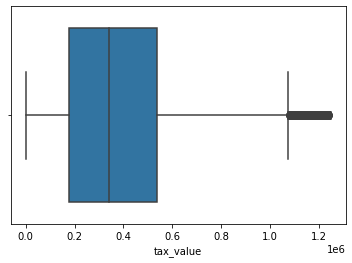

          tax_value
count  2.590200e+04
mean   3.865320e+05
std    2.624256e+05
min    1.000000e+03
25%    1.778322e+05
50%    3.421535e+05
75%    5.360000e+05
max    1.247451e+06


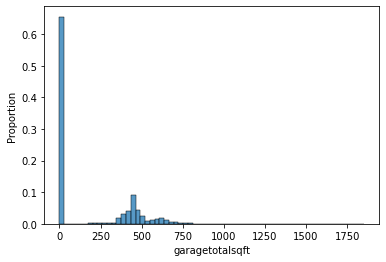

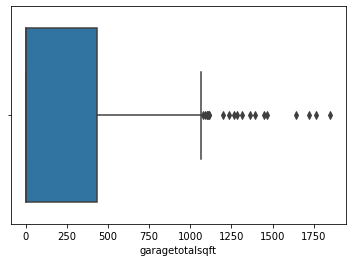

       garagetotalsqft
count     25902.000000
mean        166.791908
std         239.194788
min           0.000000
25%           0.000000
50%           0.000000
75%         430.000000
max        1851.000000


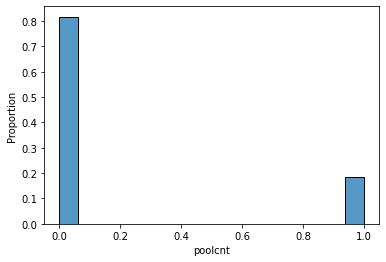

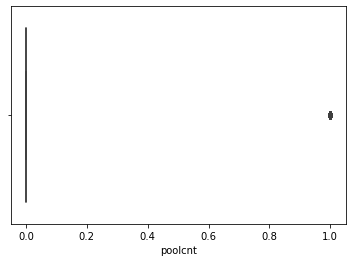

            poolcnt
count  25902.000000
mean       0.183268
std        0.386893
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        1.000000


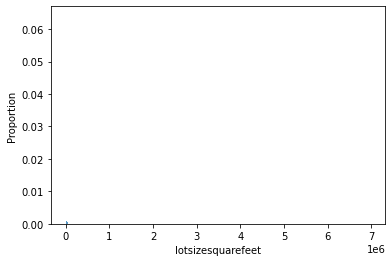

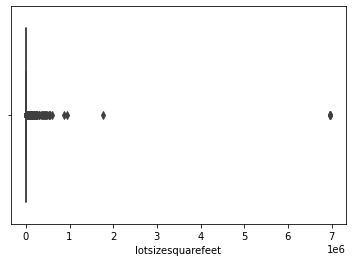

       lotsizesquarefeet
count       2.590200e+04
mean        1.058781e+04
std         1.080170e+05
min         4.800000e+02
25%         5.500000e+03
50%         6.706000e+03
75%         8.263000e+03
max         6.971010e+06


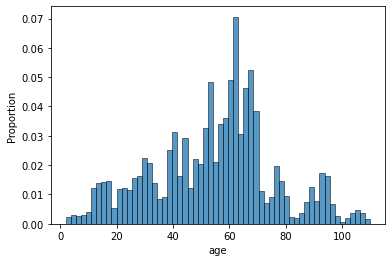

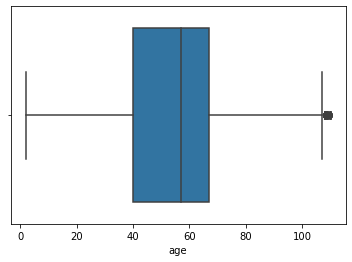

                age
count  25902.000000
mean      54.339163
std       21.566126
min        2.000000
25%       40.000000
50%       57.000000
75%       67.000000
max      110.000000


In [23]:
# define quantitative columns
quantitative_columns = [col for col in train.columns if train[col].dtype != 'object']

# for each of those columns:
for col in quantitative_columns:

        # display a histogram of that column's distribution
        sns.histplot(train[col], stat='proportion')
        plt.show()

        # display a boxplot of that column's distribution
        sns.boxplot(train[col])
        plt.show()

        # display the summary statistics of the distribution
        print(pd.DataFrame(train[col].describe()))

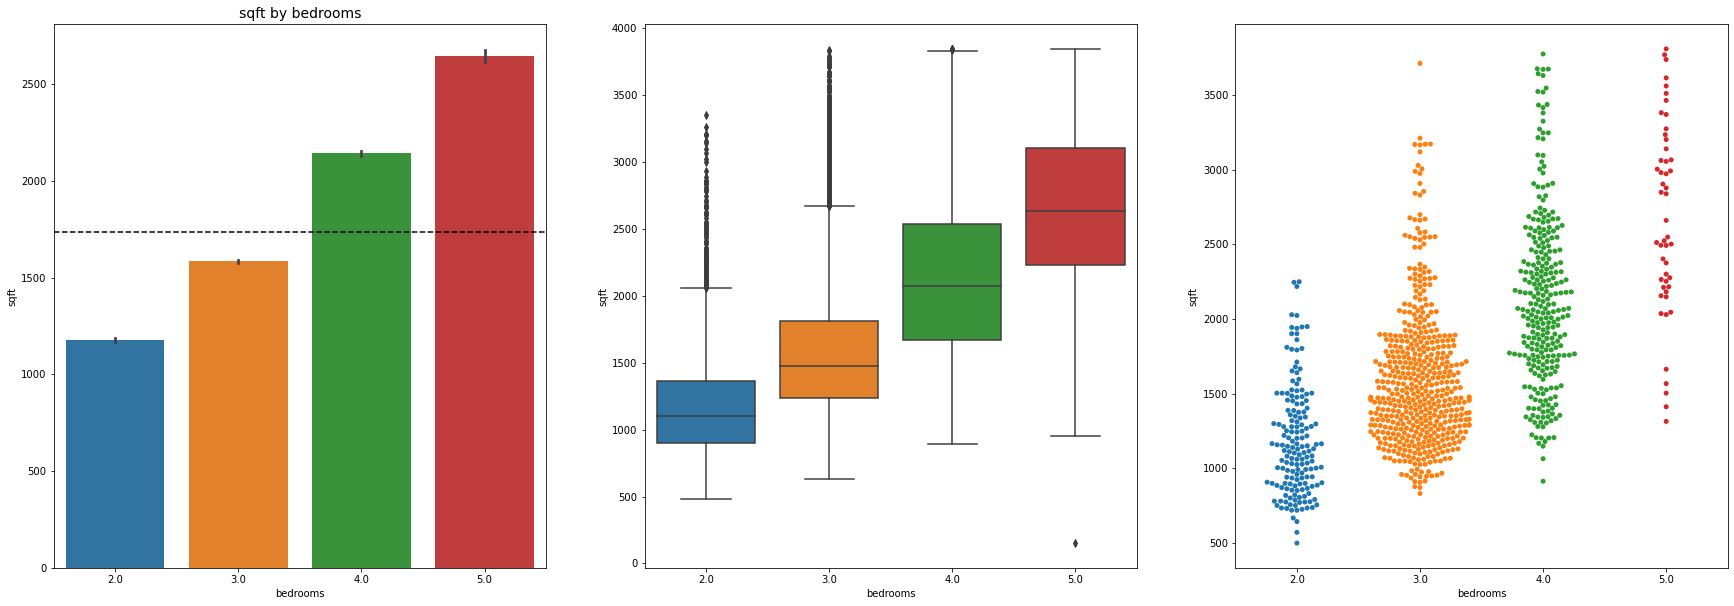

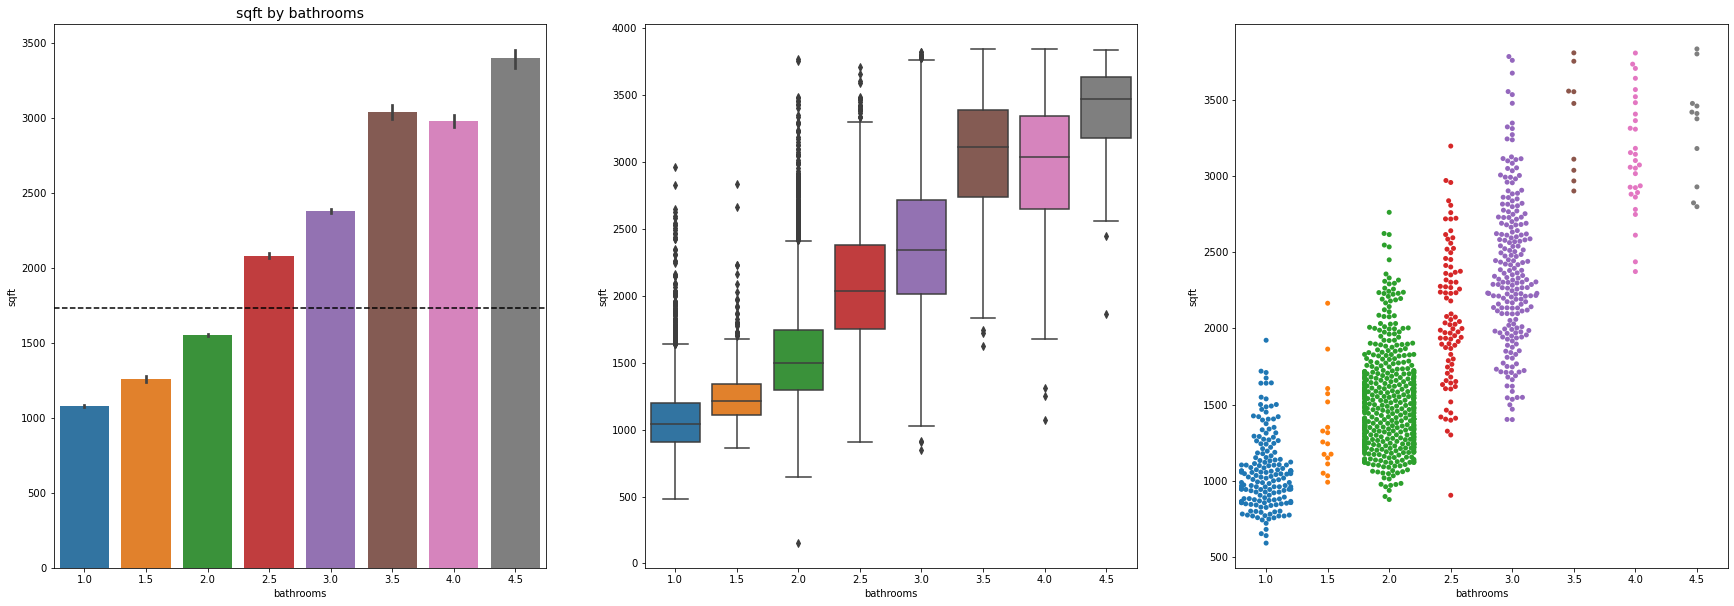

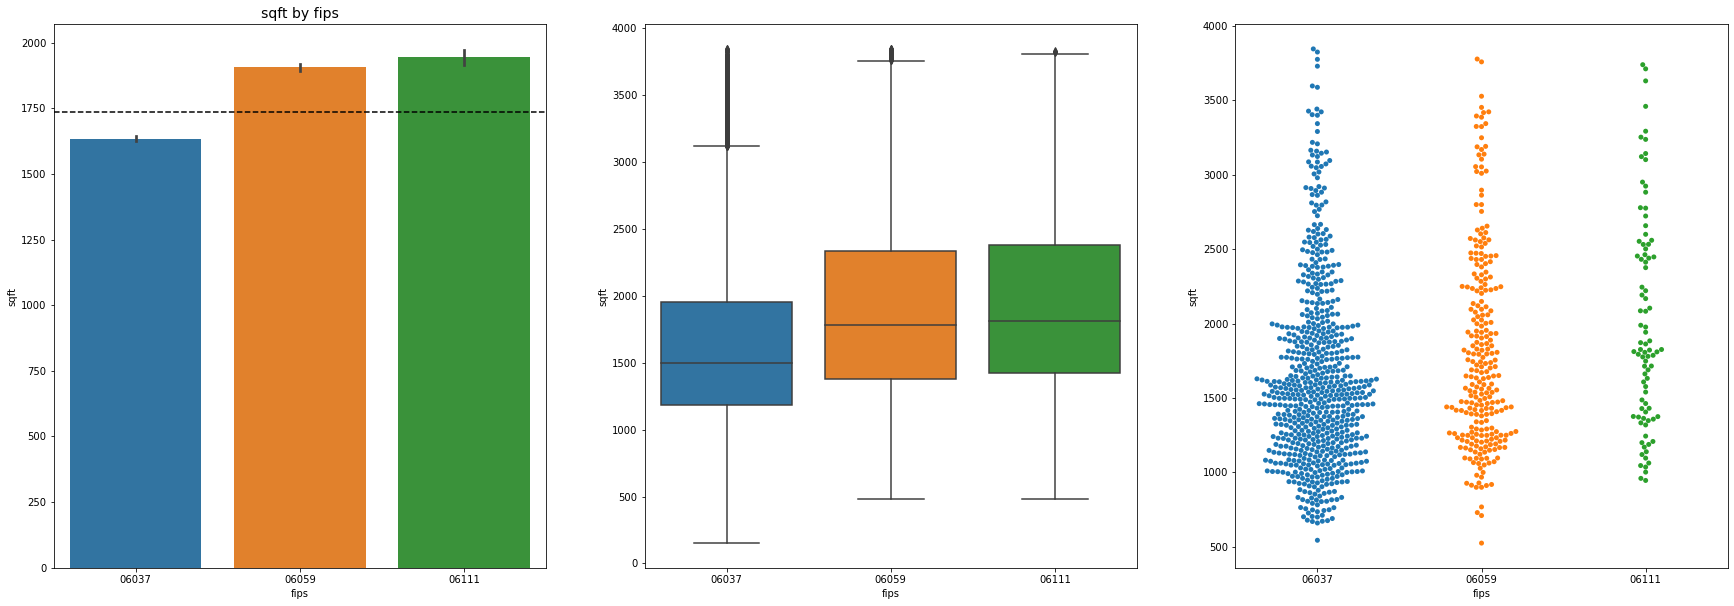

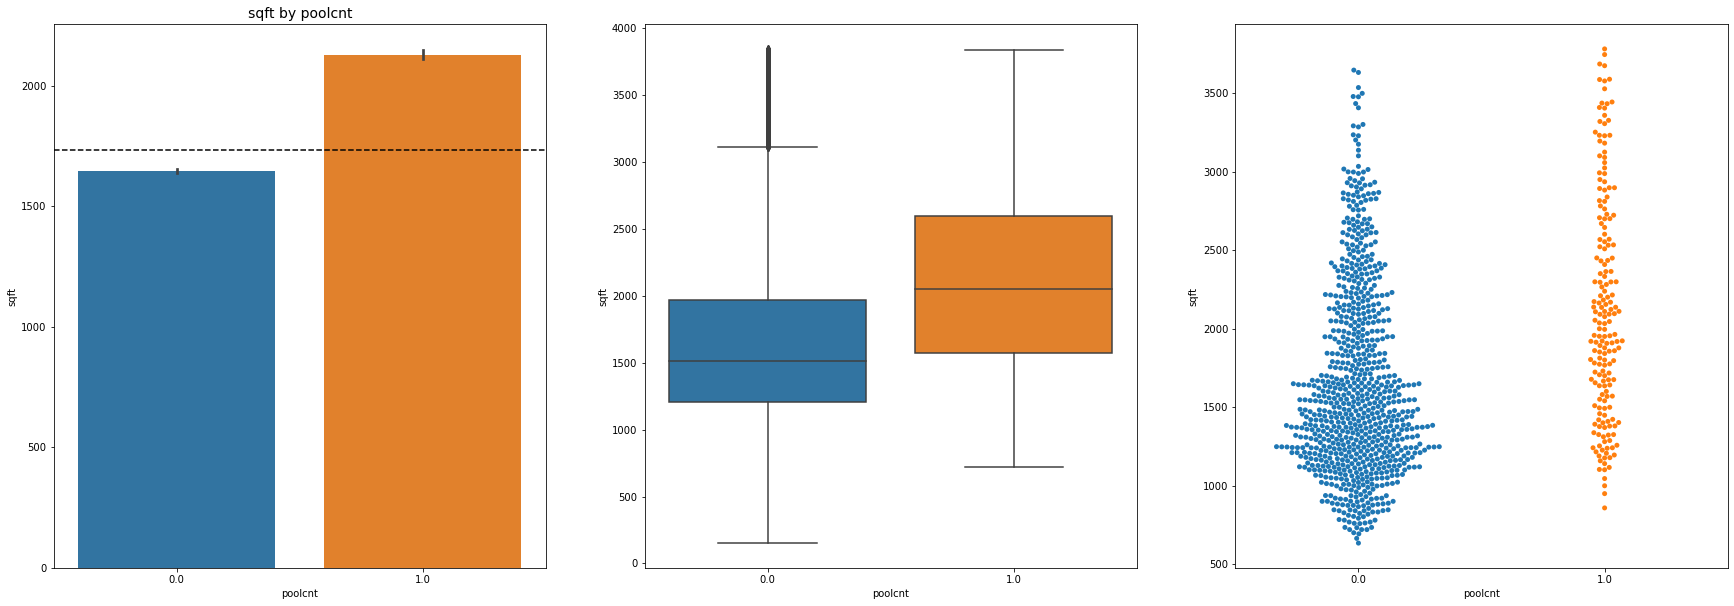

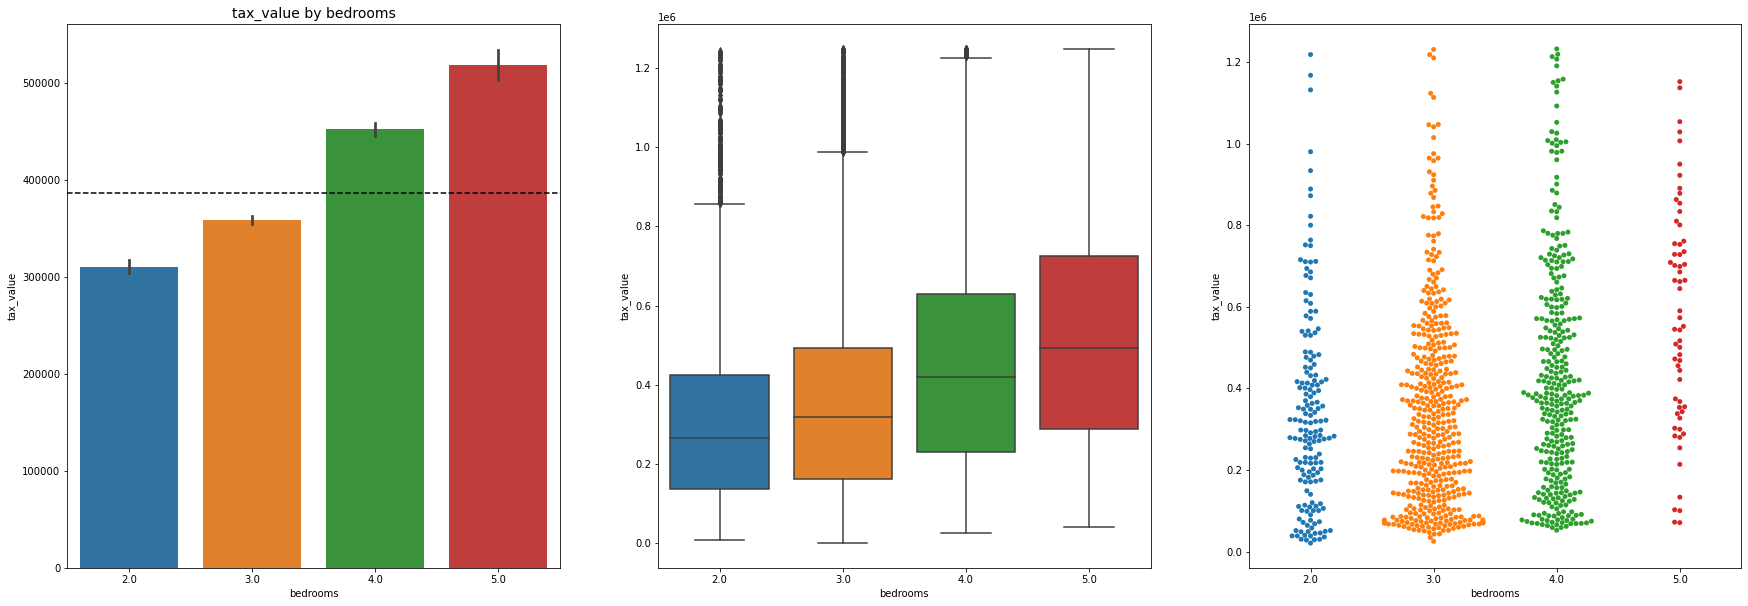

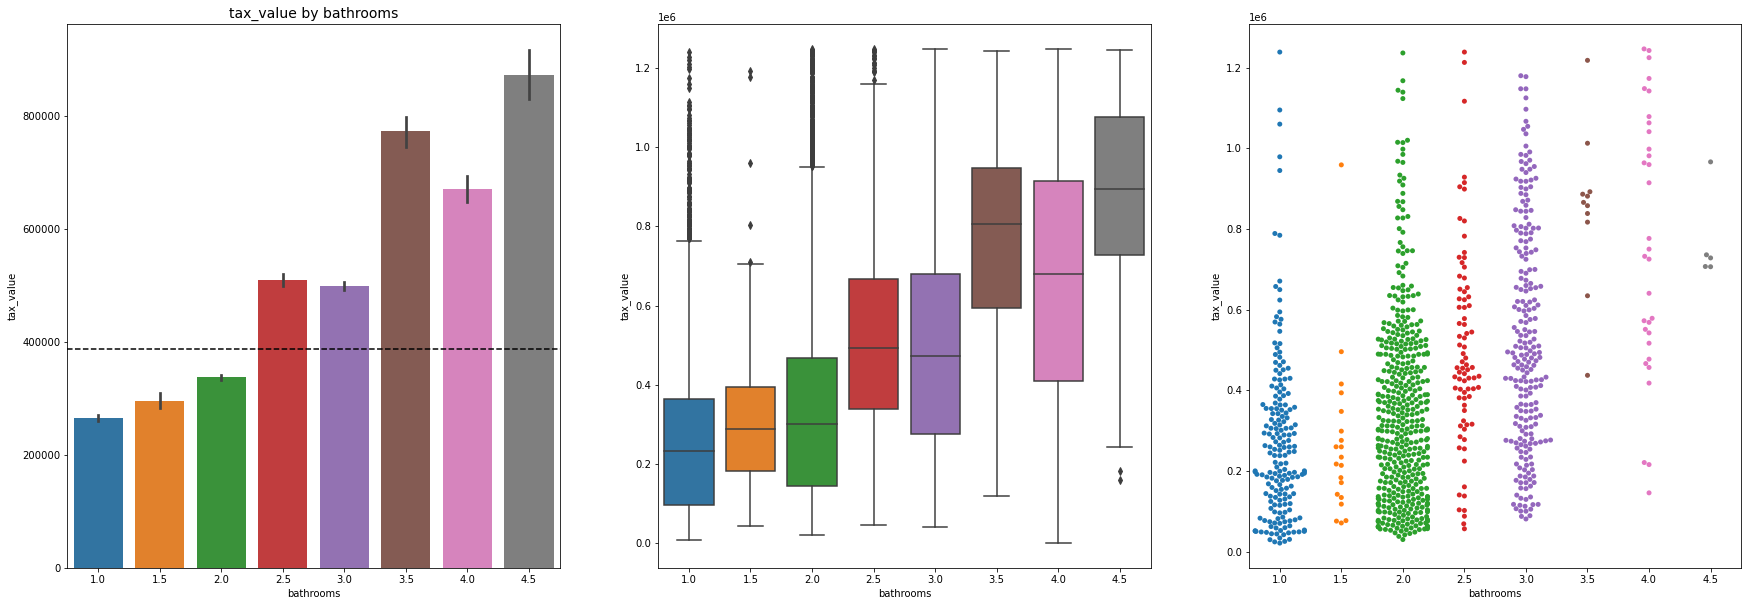

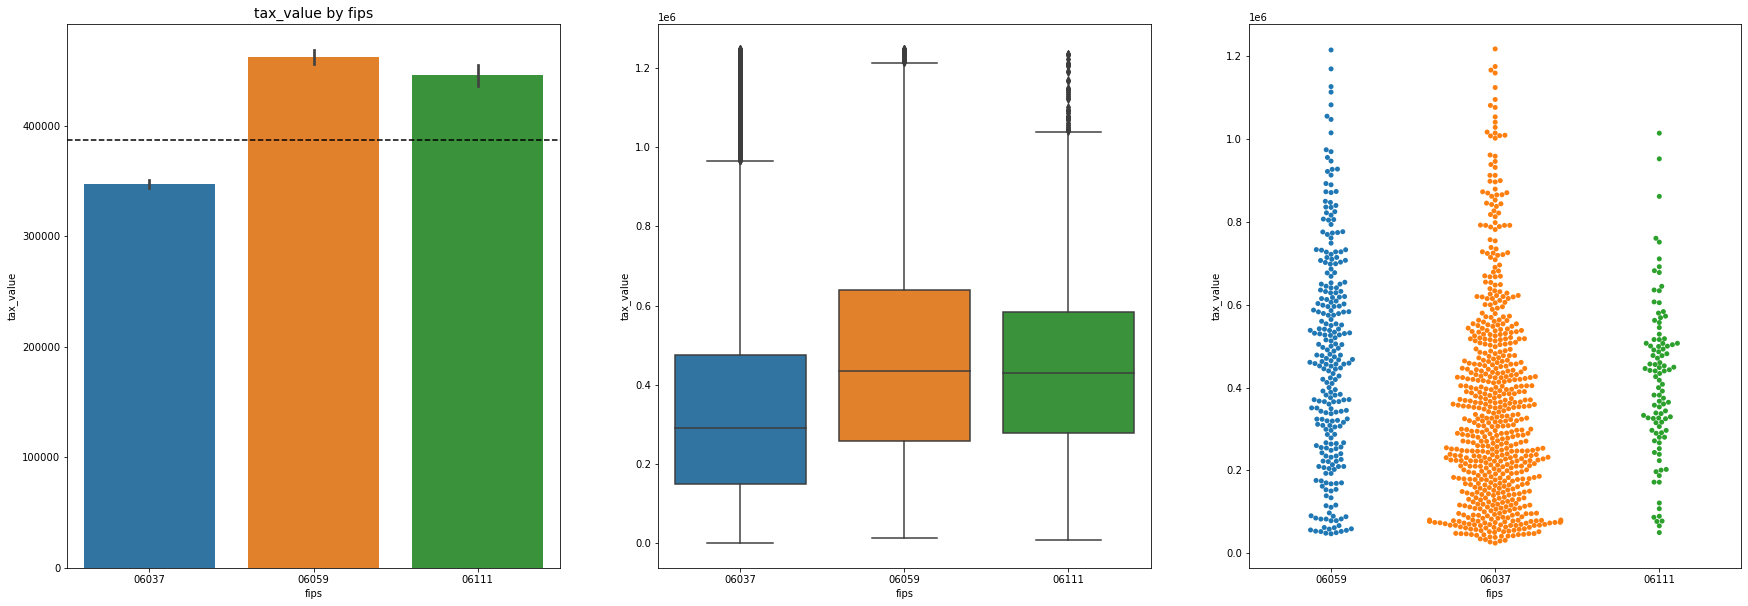

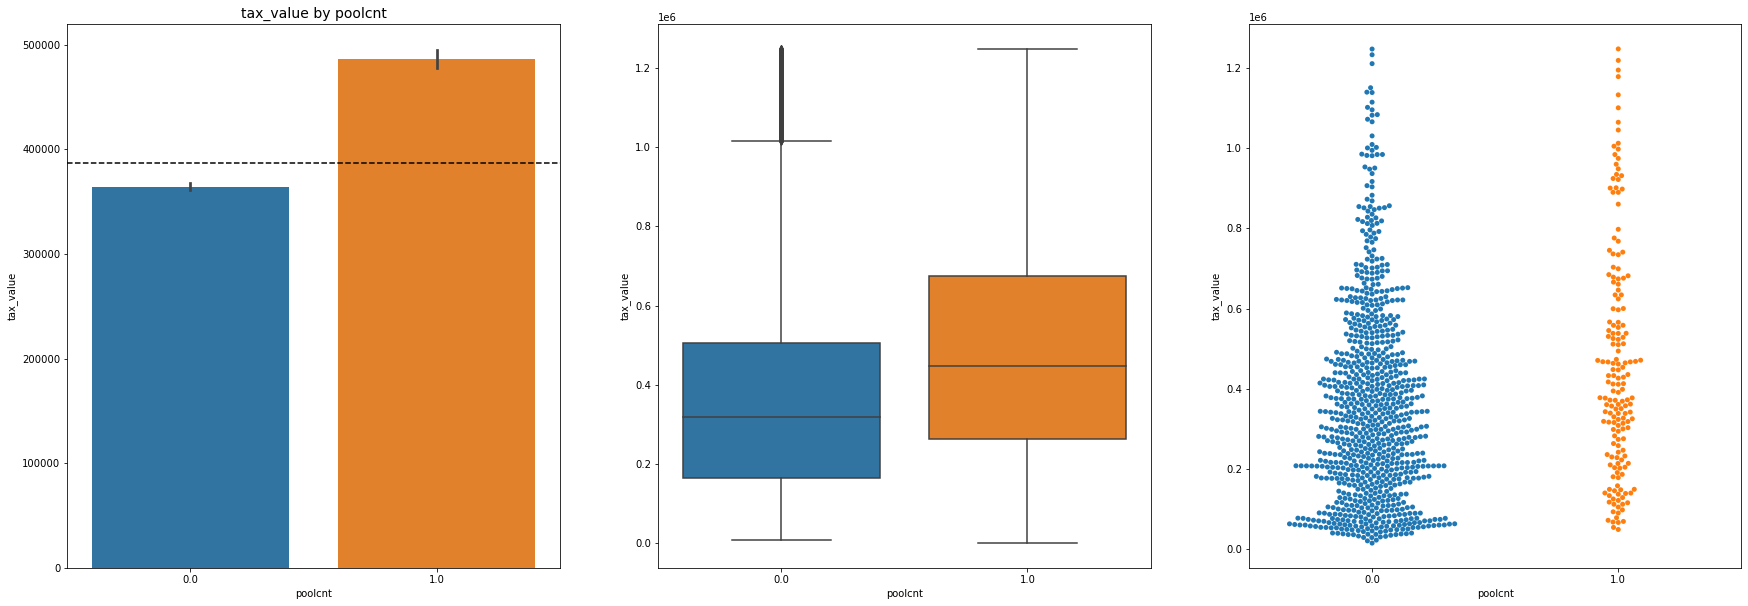

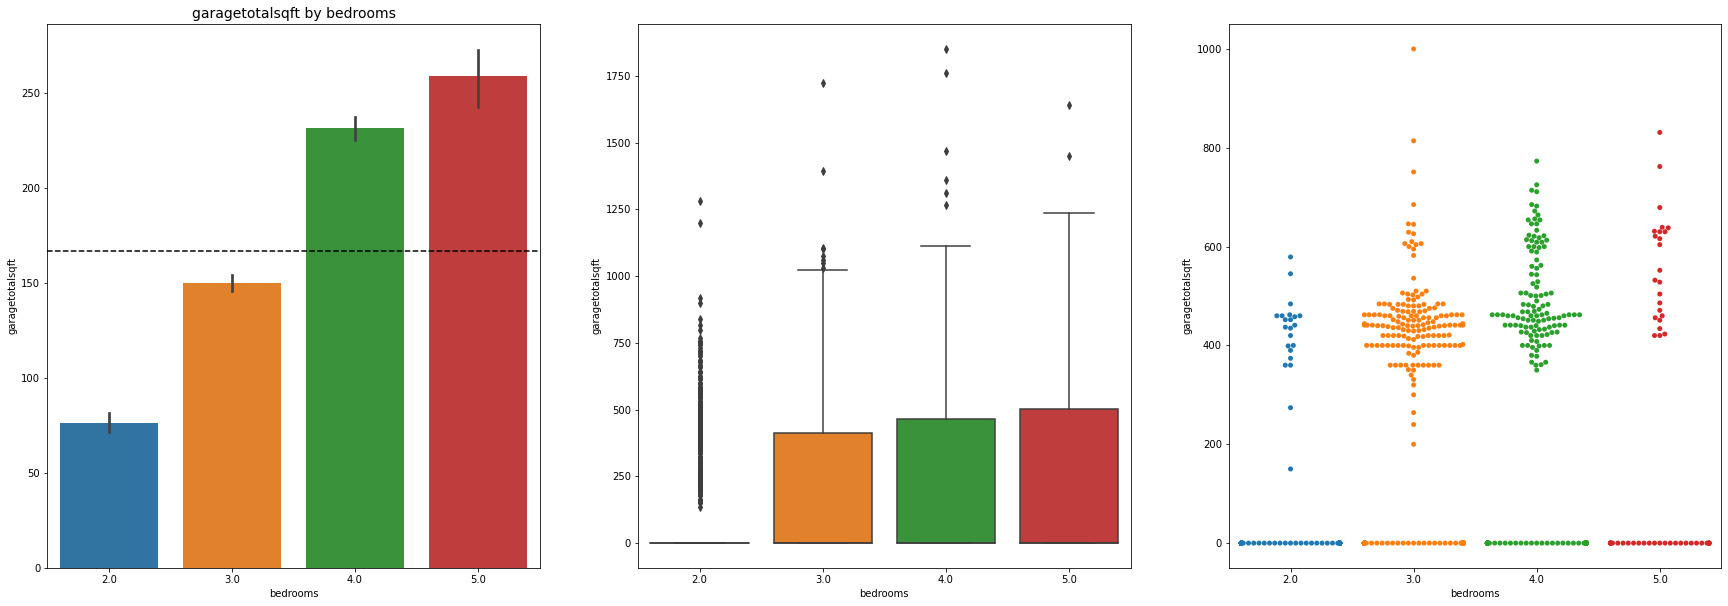

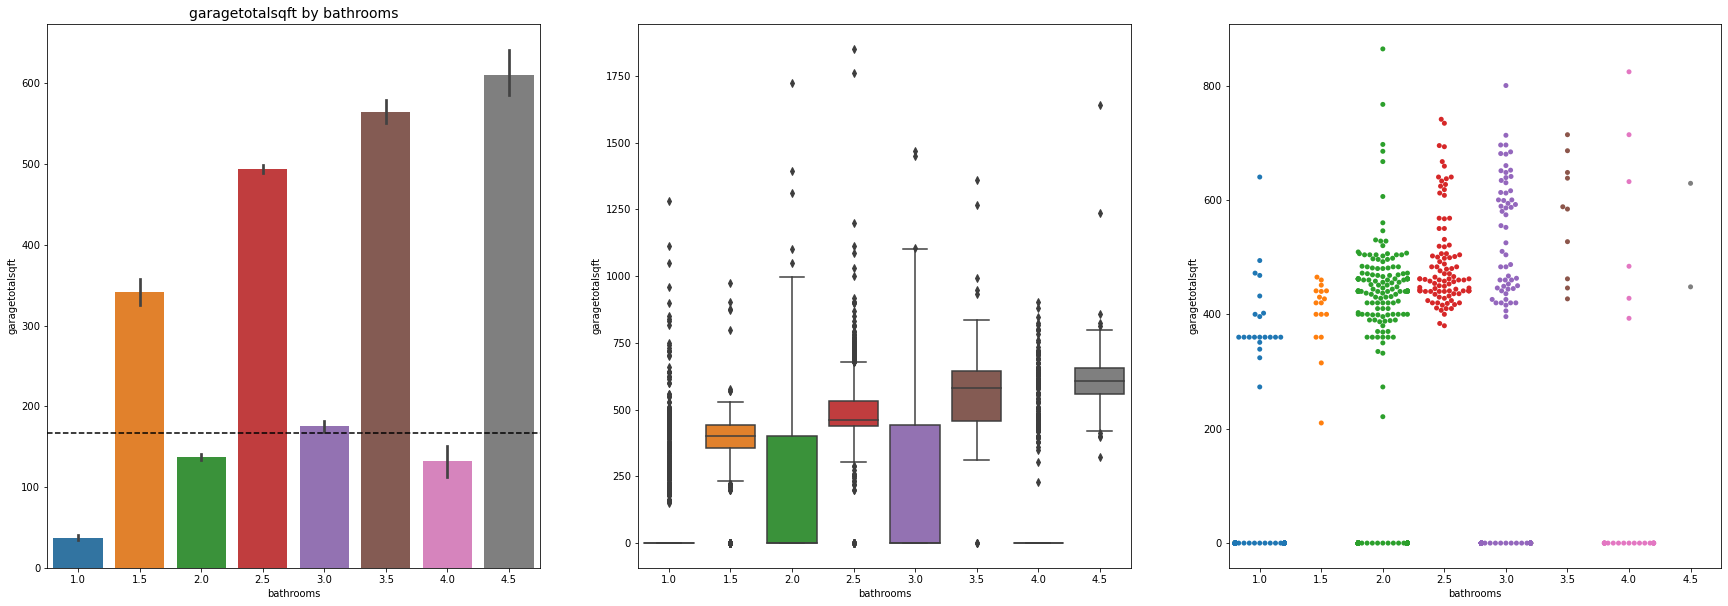

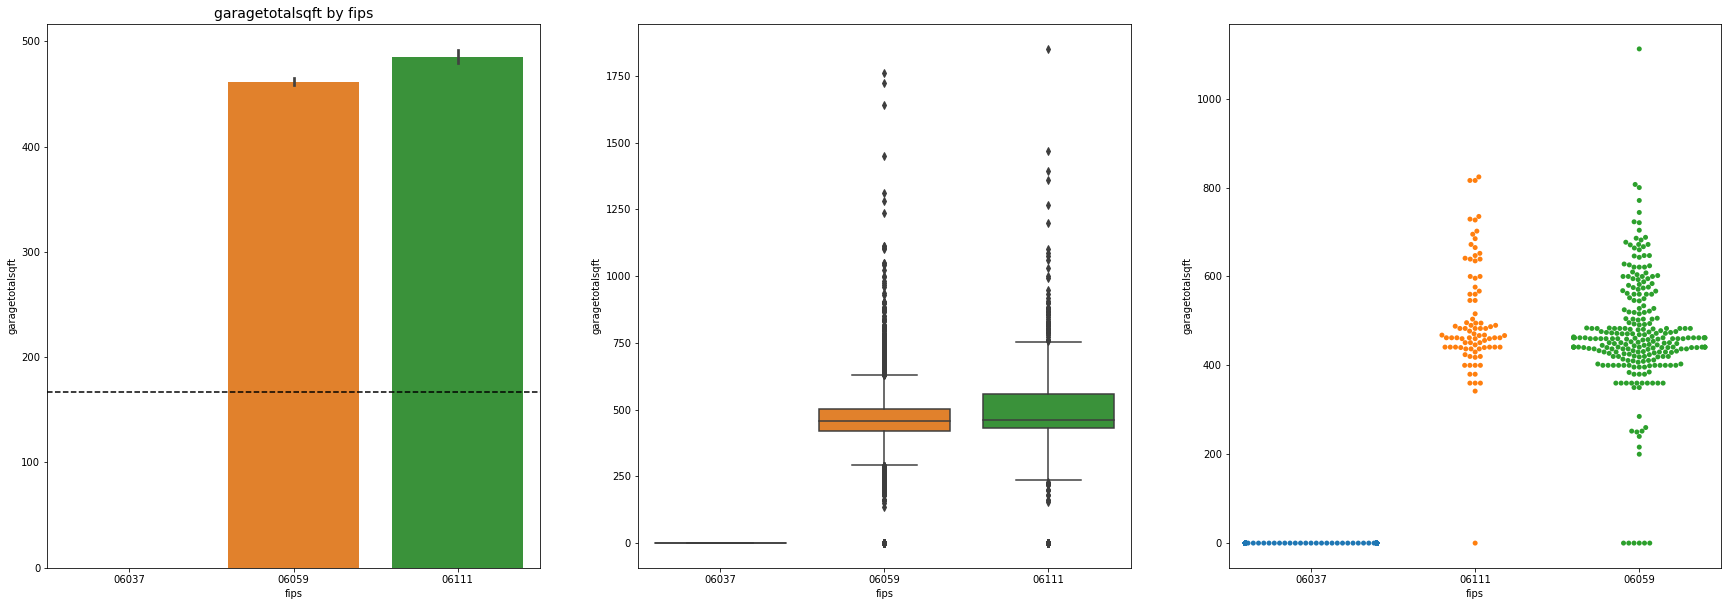

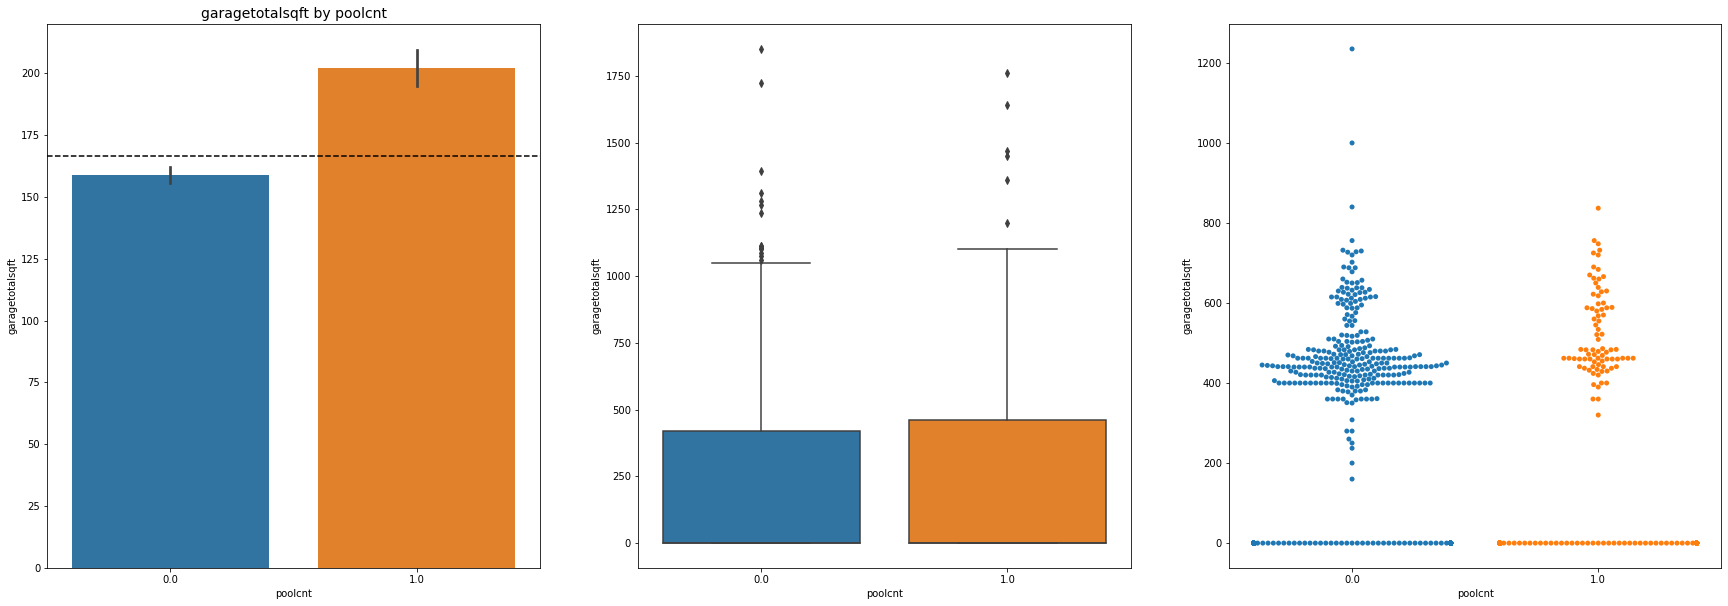

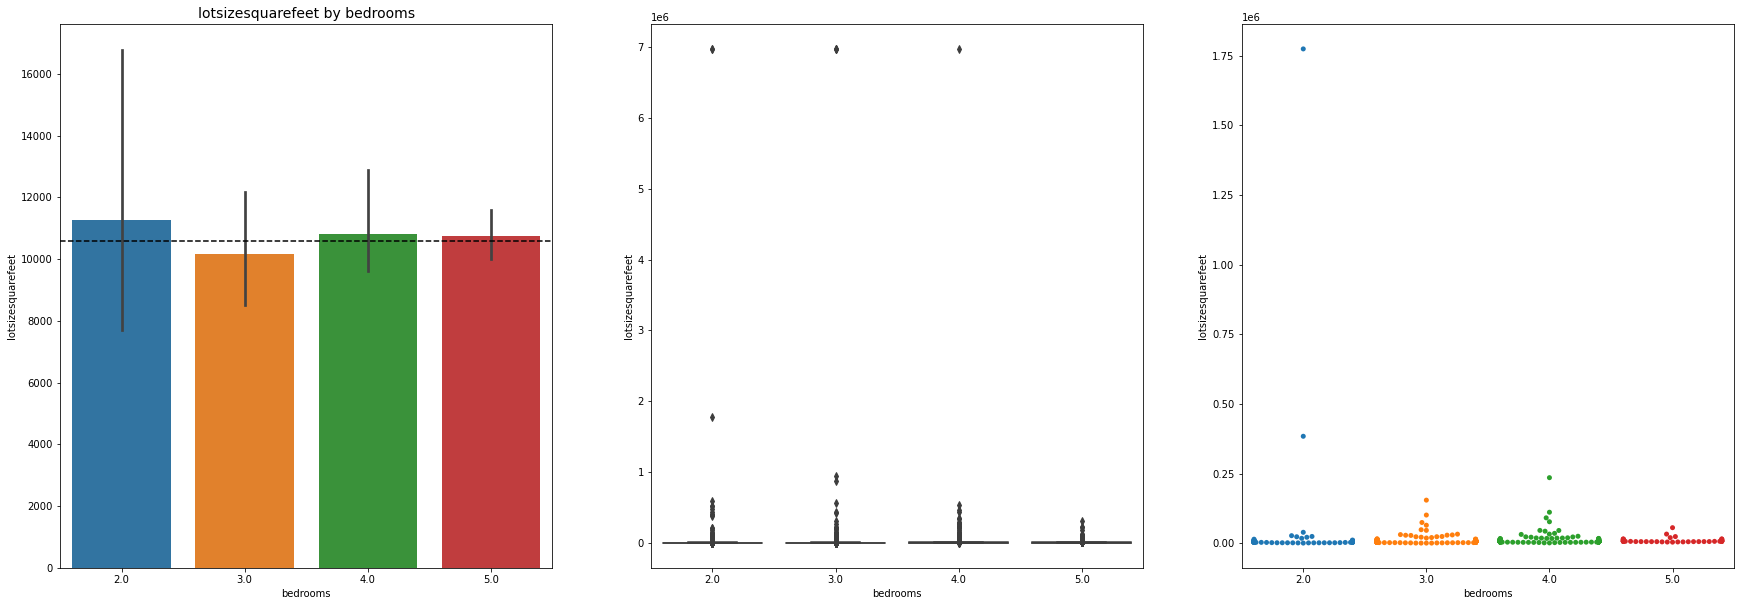

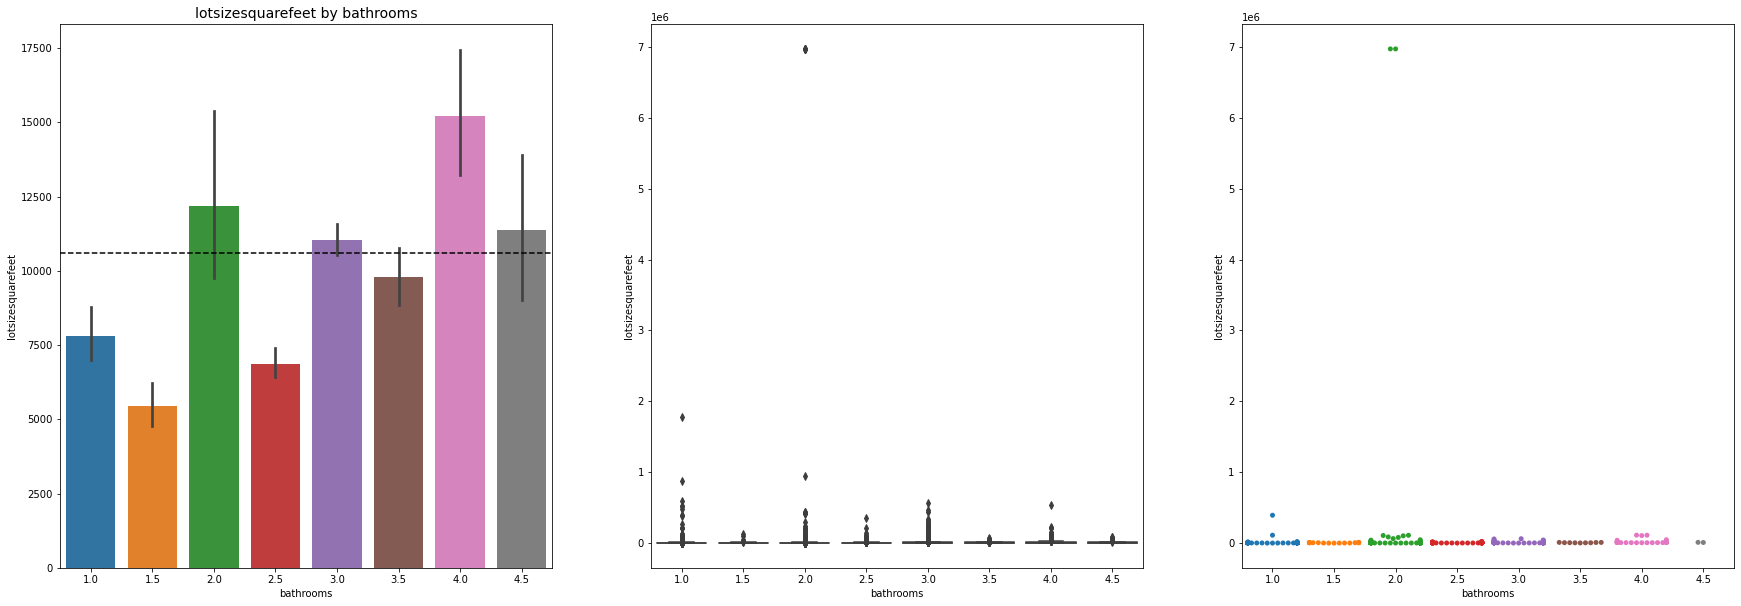

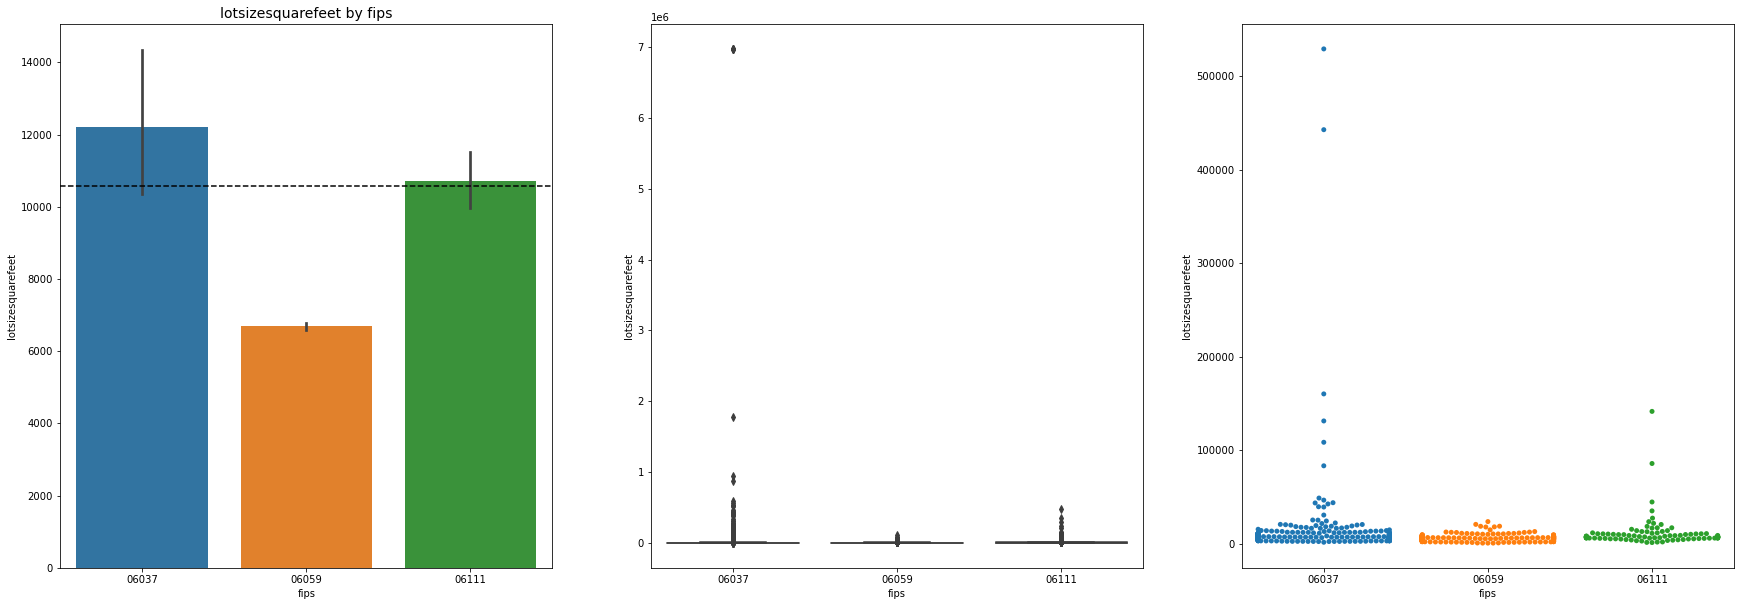

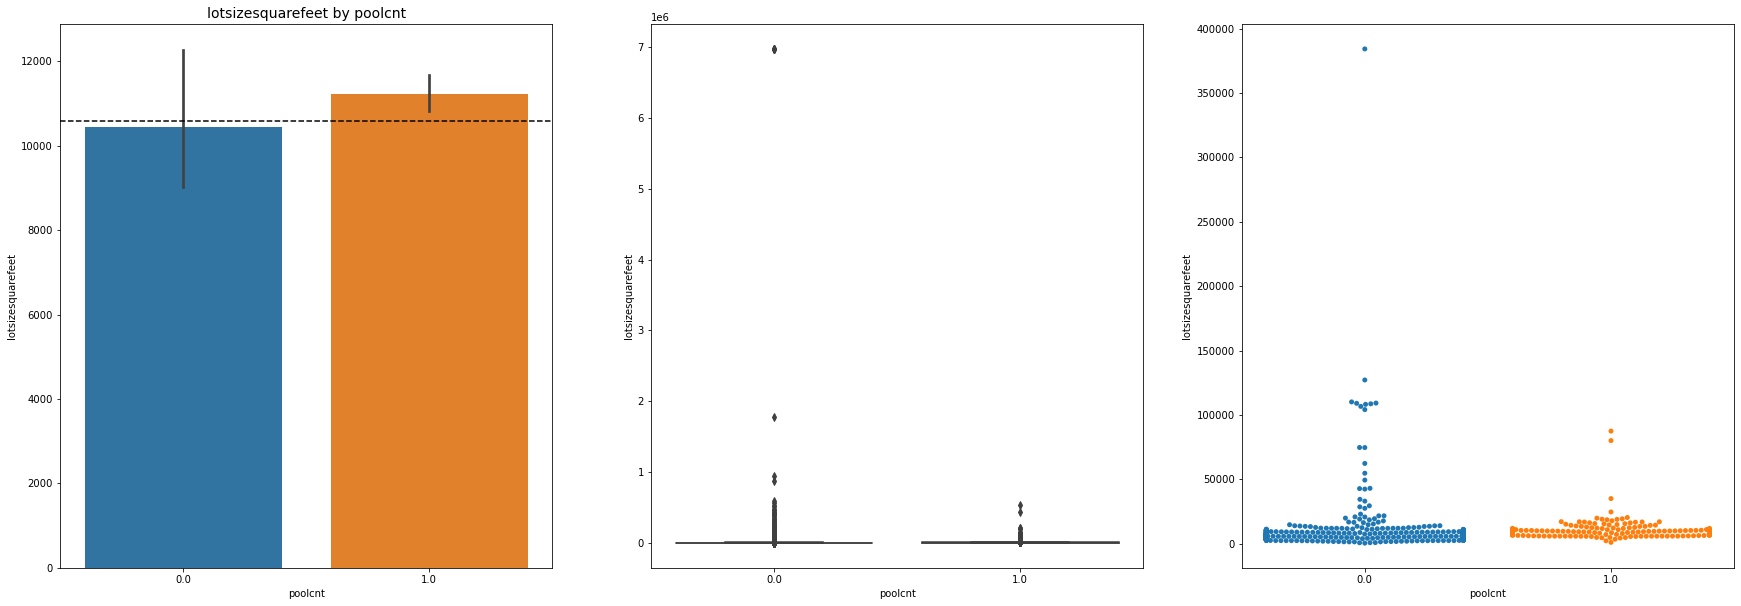

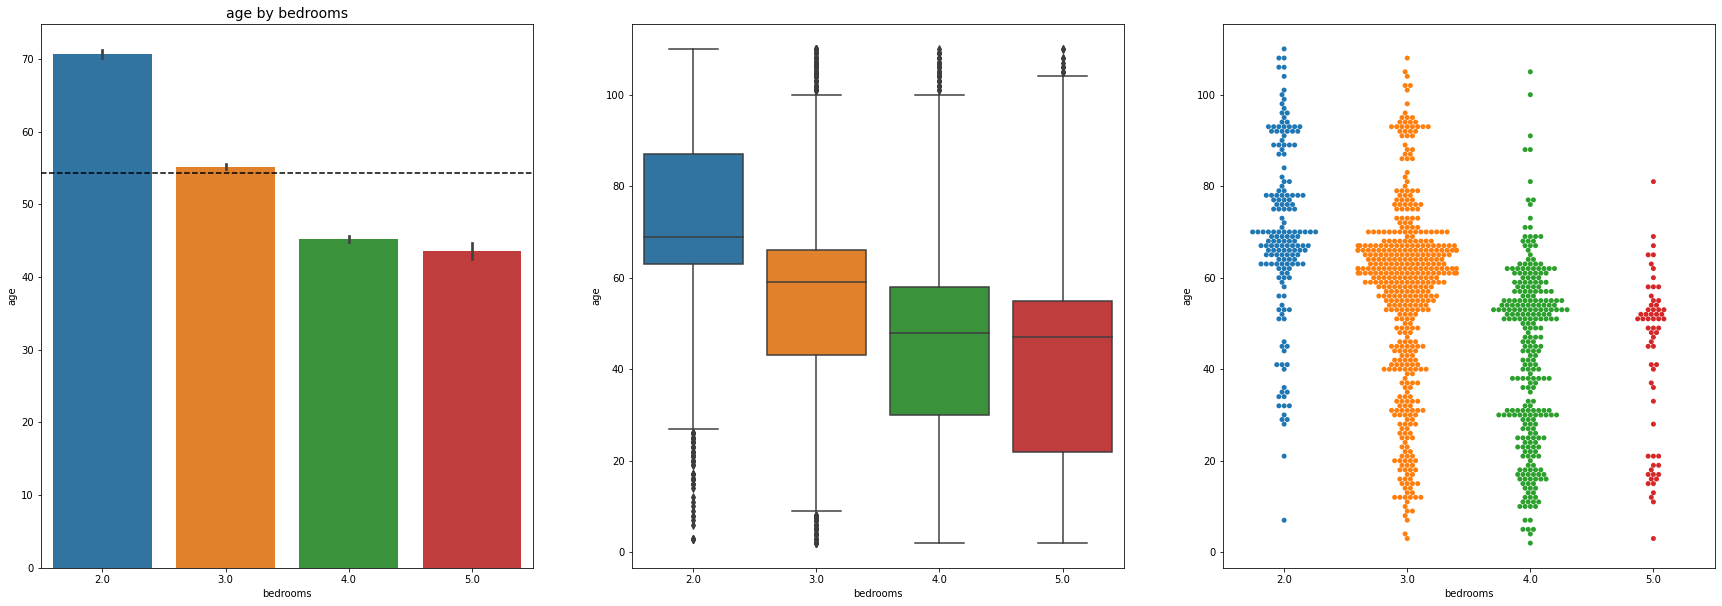

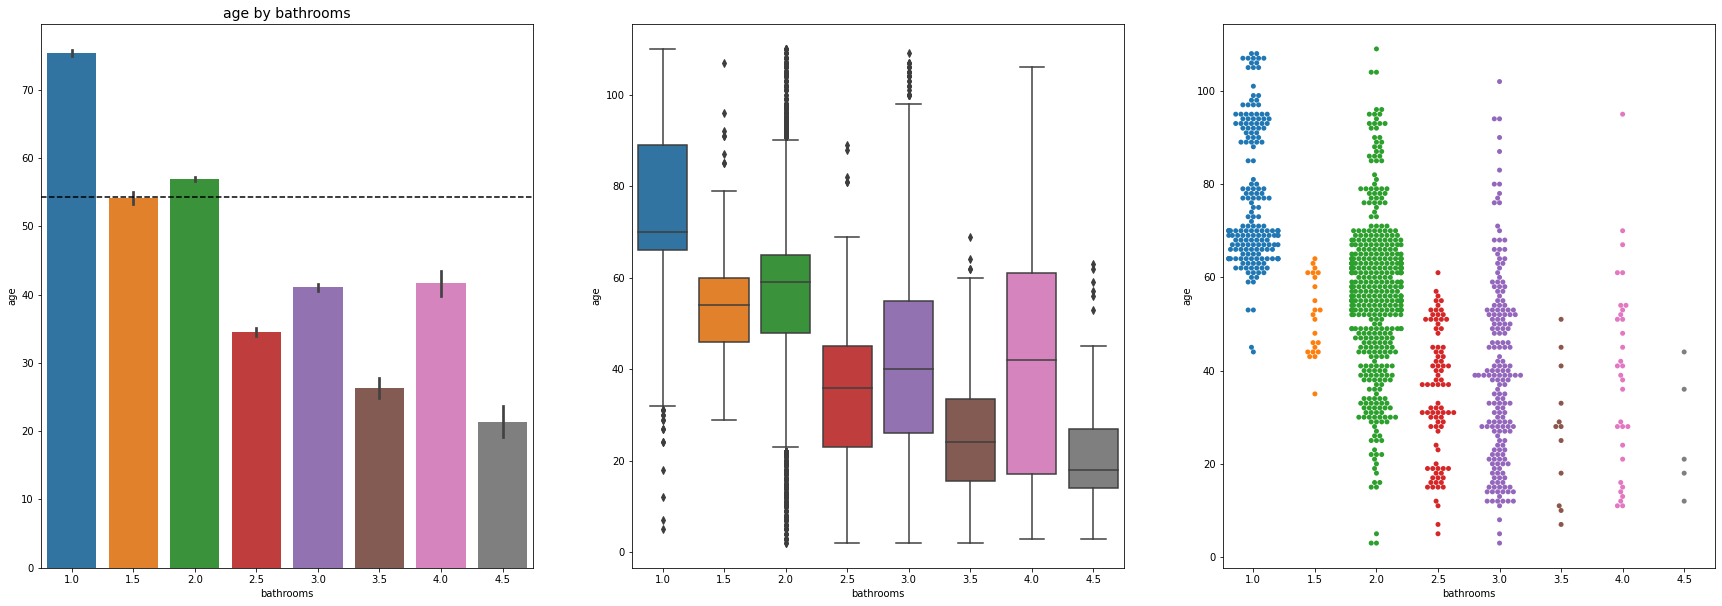

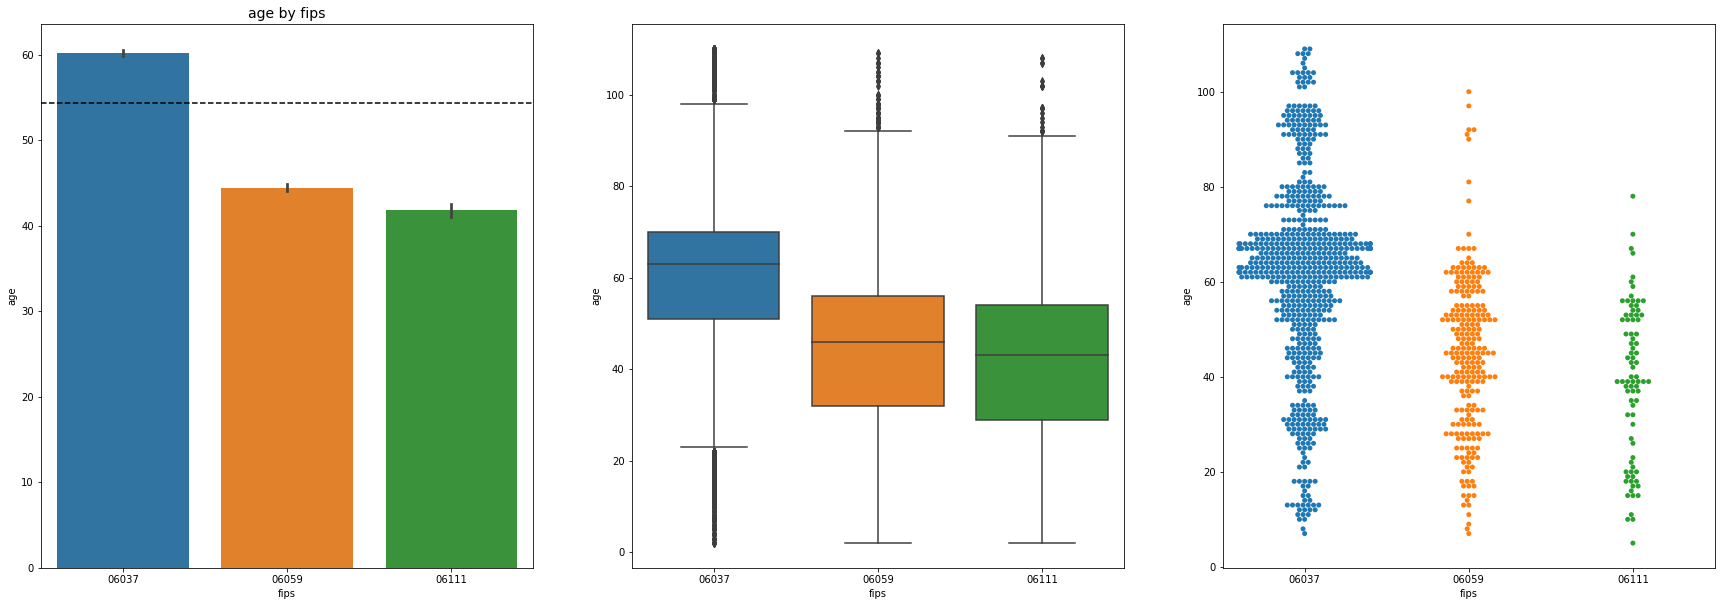

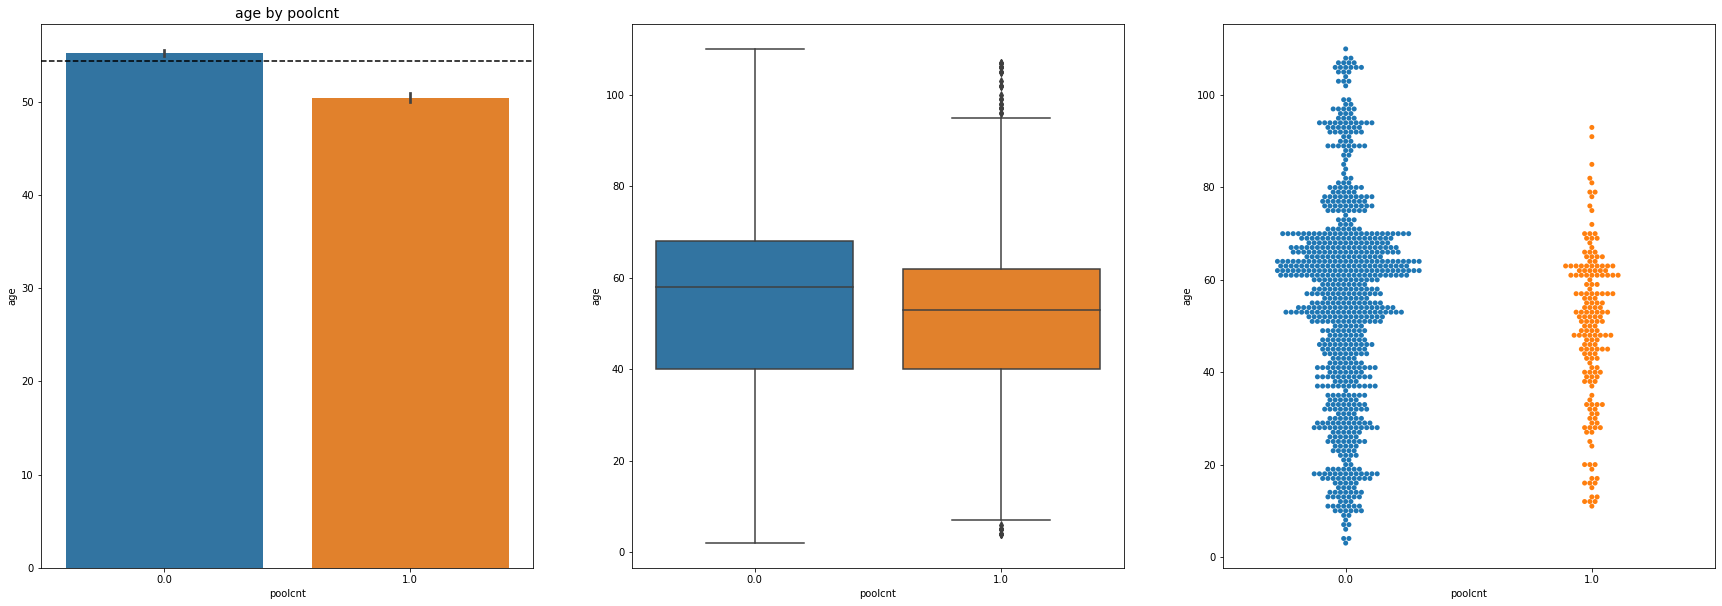

In [24]:
categ_vars = [col for col in train.columns if (train[col].dtype == 'object') or (len(train[col].unique()) < 10)]
cont_vars = [col for col in train.columns if (col not in categ_vars)]

def plot_categorical_and_continuous_vars(train, categ_vars, cont_vars):    
    for cont_var in cont_vars:
        for categ_var in categ_vars:

            plt.figure(figsize=(30,10))
            
            # barplot of average values
            plt.subplot(131)
            sns.barplot(data=train,
                        x=categ_var,
                        y=cont_var)
            plt.axhline(train[cont_var].mean(), 
                        ls='--', 
                        color='black')
            plt.title(f'{cont_var} by {categ_var}', fontsize=14)
            
            # box plot of distributions
            plt.subplot(132)
            sns.boxplot(data=train,
                          x=categ_var,
                          y=cont_var)
            
            # swarmplot of distributions
            
            # for larger datasets, use a sample of n=1000
            if len(train) > 1000:
                train_sample = train.sample(1000)

                plt.subplot(133)
                sns.swarmplot(x=categ_var,
                              y=cont_var,
                              data=train_sample)
            
            # for smaller datasets, plot all data
            else:
                plt.subplot(133)
                sns.swarmplot(x=categ_var,
                              y=cont_var,
                              data=train)
            plt.show()

plot_categorical_and_continuous_vars(train, categ_vars, cont_vars)

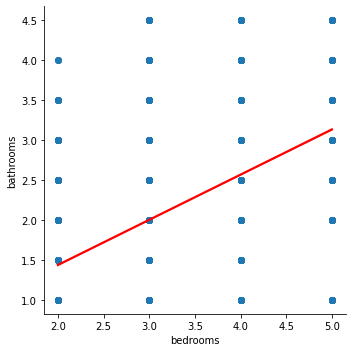

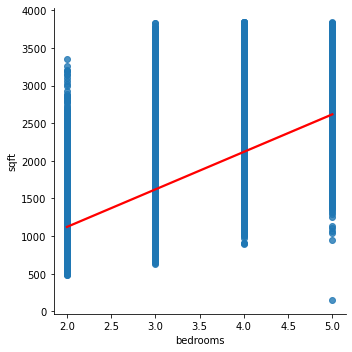

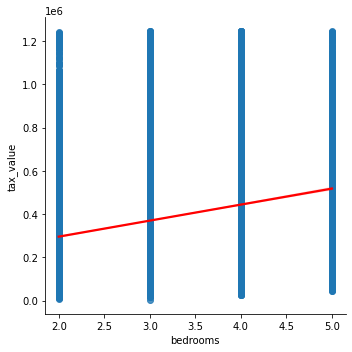

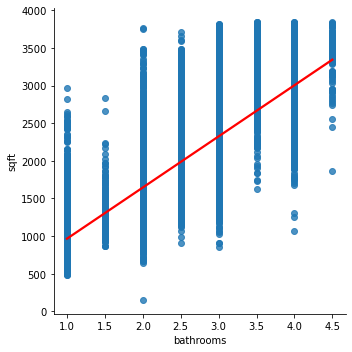

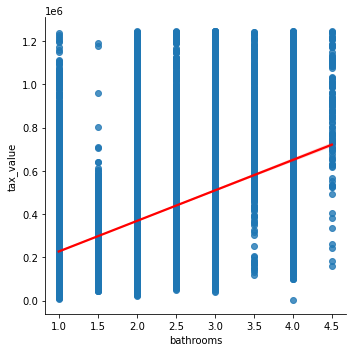

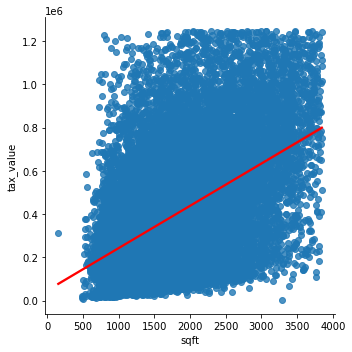

In [25]:
quant_features = ['bedrooms', 'bathrooms', 'sqft', 'tax_value']

import itertools

def plot_variable_pairs(train, features):
    feature_combos = list(itertools.combinations(features, 2))
    for combo in feature_combos:
        sns.lmplot(x=combo[0], y=combo[1], data=train, line_kws={'color': 'red'})
        plt.show()
        
plot_variable_pairs(train, quant_features)
        

### Further Exploration: which features have the highest correlations with tax_value?

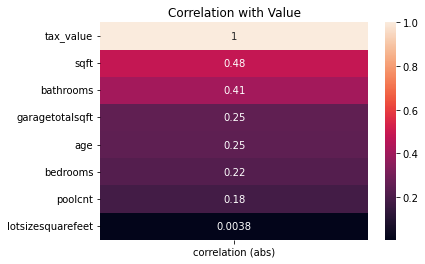

In [26]:
corr = pd.DataFrame(train.corr().abs().tax_value).sort_values(by='tax_value', ascending=False)
corr.columns = ['correlation (abs)']
sns.heatmap(corr, annot=True)
plt.title('Correlation with Value')
plt.show()

We can see that of our features, sqft and bathrooms have the highest correlation with the tax value of the home. The .48 and .41 r values are considerably higher than the correlation with bedrooms at r = .23. 

Are these correlation values statistically significant?

In [27]:
import scipy.stats as stats

def chi2_test(data_for_category1, data_for_category2, alpha=.05):
    '''
    This function takes in two array-like objects of categorical data (two columns
    of a pandas dataframe is the intended use case) and uses scipy.stats to 
    conduct a chi^2 test for independence. 
    It prints crosstabs of the observed and expected values, and determines whether to 
    reject the null hypothesis based on a given value of alpha. 
    '''
    # create dataframe of observed values
    observed = pd.crosstab(data_for_category1, data_for_category2)
    
    # conduct test using scipy.stats.chi2_contingency() test
    chi2, p, degf, expected = stats.chi2_contingency(observed)
    
    # round the expected values
    expected = expected.round(1)
    
    # output
    print('Observed\n')
    print(observed.values)
    print('---\nExpected\n')
    print(expected)
    print('---\n')
    print(f'chi^2 = {chi2:.4f}')
    print(f'p     = {p:.4f}')
    
    # evaluate the hypothesis against the established alpha value
    if p < alpha:
        print('\nReject H0')
    else: 
        print('\nFail to Reject H0')

### Further exploration: Is there a significant correlation between number of bathrooms and value?

Testing correlation between number of bathrooms and tax value:

H0: There is no linear correlation between the number of bathrooms and tax value.
H1: There is a linear correlation between the number of bathrooms and tax value. 

In [28]:
alpha = .05
r, p = stats.pearsonr(train.bathrooms, train.tax_value)
r, p

(0.40585910811535164, 0.0)

In [29]:
if p < alpha:
    print('Reject H0')
else: 
    print('Fail to reject H0')

Reject H0


With a p-value of virtually 0, we reject the null hypothesis and proceed under the assumption that there is a linear relationship between number of bathrooms and tax_value. since this relationship is unlikely to be due to chance. 

### Further exploration: Is there a significant correlation between a home's square footage and it's value?

In [30]:
alpha = .05
r, p = stats.pearsonr(train.sqft, train.tax_value)
r, p

(0.4832467572984189, 0.0)

In [31]:
if p < alpha:
    print('Reject H0')
else: 
    print('Fail to reject H0')

Reject H0


With a p-value of virtually 0, we reject the null hypothesis and proceed under the assumption that there is a linear relationship between the square footage of the home and tax_value, since this relationship in our sample is unlikely to be due to chance. 

### Further exploration: Is there a significant correlation between the number of bedrooms in a home and it's value?

In [32]:
alpha = .05
r, p = stats.pearsonr(train.bedrooms, train.tax_value)
r, p

(0.22386346507799912, 1.533561874986849e-291)

In [33]:
if p < alpha:
    print('Reject H0')
else: 
    print('Fail to reject H0')

Reject H0


With a p-value of virtually 0, we reject the null hypothesis and proceed under the assumption that there is a linear relationship between the number of bedrooms in a home and tax_value, since this relationship in our sample is unlikely to be due to chance. 

# Modeling

For the first iteration of the model, we will only use bedrooms, bathrooms, and sqft to estimate tax value. We may add other features in later iterations. But we will drop other features here now:

In [34]:
train.head()

,bedrooms,bathrooms,sqft,tax_value,fips,garagetotalsqft,poolcnt,lotsizesquarefeet,age
50445,5.0,3.0,2981.0,420931.0,06037,0.0,0.0,9167.0,17
41360,3.0,4.5,3614.0,766109.0,06059,569.0,1.0,8400.0,26
39237,2.0,1.0,1014.0,116006.0,06037,0.0,0.0,5197.0,70
5186,5.0,3.0,3473.0,394597.0,06037,0.0,1.0,7470.0,45
26320,2.0,2.0,1361.0,556104.0,06037,0.0,0.0,5072.0,92


In [35]:
target = 'tax_value'

In [36]:
# scale quantitative features

quant_features = [col for col in df.columns if (df[col].dtype != 'object') & (col != target)]

# establish empty dataframes for storing scaled dataset
train_scaled = pd.DataFrame(index=train.index)
validate_scaled = pd.DataFrame(index=validate.index)
test_scaled = pd.DataFrame(index=test.index)

# screate and fit the scaler
scaler = MinMaxScaler().fit(train[quant_features])

# adding scaled features to scaled dataframes
train_scaled[quant_features] = scaler.transform(train[quant_features])
validate_scaled[quant_features] = scaler.transform(validate[quant_features])
test_scaled[quant_features] = scaler.transform(test[quant_features])

# add 'scaled' prefix to columns
for feature in quant_features:
    train_scaled = train_scaled.rename(columns={feature: f'scaled_{feature}'})
    validate_scaled = validate_scaled.rename(columns={feature: f'scaled_{feature}'})
    test_scaled = test_scaled.rename(columns={feature: f'scaled_{feature}'})
    
# concat scaled features to original train, validate, test df's
train = pd.concat([train, train_scaled], axis=1)
validate = pd.concat([validate, validate_scaled], axis=1)
test = pd.concat([test, test_scaled], axis=1)

#identify scaled features
scaled_features = [col for col in train.columns if col.startswith('scaled_')]

In [37]:
train.describe()

,bedrooms,bathrooms,sqft,tax_value,garagetotalsqft,poolcnt,lotsizesquarefeet,age,scaled_bedrooms,scaled_bathrooms,scaled_sqft,scaled_garagetotalsqft,scaled_poolcnt,scaled_lotsizesquarefeet,scaled_age
count,25902.000000,25902.000000,25902.000000,2.590200e+04,25902.000000,25902.000000,2.590200e+04,25902.000000,25902.000000,25902.000000,25902.000000,25902.000000,25902.000000,25902.000000,25902.000000
mean,3.226855,2.130299,1734.282063,3.865320e+05,166.791908,0.183268,1.058781e+04,54.339163,0.408952,0.322943,0.428338,0.090109,0.183268,0.001450,0.484622
std,0.792883,0.754323,648.638044,2.624256e+05,239.194788,0.386893,1.080170e+05,21.566126,0.264294,0.215521,0.175592,0.129225,0.386893,0.015496,0.199686
min,2.000000,1.000000,152.000000,1.000000e+03,0.000000,0.000000,4.800000e+02,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.000000,2.000000,1246.000000,1.778322e+05,0.000000,0.000000,5.500000e+03,40.000000,0.333333,0.285714,0.296156,0.000000,0.000000,0.000720,0.351852
50%,3.000000,2.000000,1590.000000,3.421535e+05,0.000000,0.000000,6.706000e+03,57.000000,0.333333,0.285714,0.389280,0.000000,0.000000,0.000893,0.509259
75%,4.000000,3.000000,2107.000000,5.360000e+05,430.000000,0.000000,8.263000e+03,67.000000,0.666667,0.571429,0.529237,0.232307,0.000000,0.001117,0.601852
max,5.000000,4.500000,3846.000000,1.247451e+06,1851.000000,1.000000,6.971010e+06,110.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [38]:
# encoding

train, test, validate = prepare.encode_zillow(train, test, validate, target)

In [39]:
train.describe()

,bedrooms,bathrooms,sqft,tax_value,garagetotalsqft,poolcnt,lotsizesquarefeet,age,scaled_bedrooms,scaled_bathrooms,scaled_sqft,scaled_garagetotalsqft,scaled_poolcnt,scaled_lotsizesquarefeet,scaled_age,enc_fips_06059,enc_fips_06111
count,25902.000000,25902.000000,25902.000000,2.590200e+04,25902.000000,25902.000000,2.590200e+04,25902.000000,25902.000000,25902.000000,25902.000000,25902.000000,25902.000000,25902.000000,25902.000000,25902.000000,25902.000000
mean,3.226855,2.130299,1734.282063,3.865320e+05,166.791908,0.183268,1.058781e+04,54.339163,0.408952,0.322943,0.428338,0.090109,0.183268,0.001450,0.484622,0.267933,0.088912
std,0.792883,0.754323,648.638044,2.624256e+05,239.194788,0.386893,1.080170e+05,21.566126,0.264294,0.215521,0.175592,0.129225,0.386893,0.015496,0.199686,0.442891,0.284622
min,2.000000,1.000000,152.000000,1.000000e+03,0.000000,0.000000,4.800000e+02,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.000000,2.000000,1246.000000,1.778322e+05,0.000000,0.000000,5.500000e+03,40.000000,0.333333,0.285714,0.296156,0.000000,0.000000,0.000720,0.351852,0.000000,0.000000
50%,3.000000,2.000000,1590.000000,3.421535e+05,0.000000,0.000000,6.706000e+03,57.000000,0.333333,0.285714,0.389280,0.000000,0.000000,0.000893,0.509259,0.000000,0.000000
75%,4.000000,3.000000,2107.000000,5.360000e+05,430.000000,0.000000,8.263000e+03,67.000000,0.666667,0.571429,0.529237,0.232307,0.000000,0.001117,0.601852,1.000000,0.000000
max,5.000000,4.500000,3846.000000,1.247451e+06,1851.000000,1.000000,6.971010e+06,110.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [40]:
# establish a baseline prediction and set up dataframe to store model performance data
train_results = model.determine_regression_baseline(train, target)

The highest performing baseline is the mean target value.


In [41]:
model_info = pd.DataFrame()
model_results = pd.DataFrame()
model_number = 0

def run_baseline(train,
                 validate,
                 target,
                 model_number,
                 model_info,
                 model_results):

    y_train = train[target]
    y_validate = validate[target]

    # identify model number
    model_number = 'baseline'
    #identify model type
    model_type = 'baseline'

    # store info about the model

    # create a dictionary containing model number and model type
    dct = {'model_number': model_number,
           'model_type': model_type}
    # append that dictionary to the model_info dataframe
    model_info = model_info.append(dct, ignore_index=True)


    # establish baseline predictions for train sample
    y_pred = baseline_pred = pd.Series(train[target].mean()).repeat(len(train))

    # get metrics
    dct = {'model_number': model_number, 
           'sample_type': 'train', 
           'metric_type': 'RMSE',
           'score': sqrt(sk.metrics.mean_squared_error(y_train, y_pred))}
    model_results = model_results.append(dct, ignore_index=True)


    # establish baseline predictions for validate sample
    y_pred = baseline_pred = pd.Series(validate[target].mean()).repeat(len(validate))

    # get metrics
    dct = {'model_number': model_number, 
           'sample_type': 'validate', 
           'metric_type': 'RMSE',
           'score': sqrt(sk.metrics.mean_squared_error(y_validate, y_pred))}
    model_results = model_results.append(dct, ignore_index=True)
    
    model_number = 0
    
    return model_number, model_info, model_results

In [42]:
model_number, model_info, model_results = run_baseline(train, validate, target, 
                                                       model_number, model_info, model_results)

In [43]:
model_info

,model_number,model_type
0,baseline,baseline


In [44]:
model_results

,model_number,sample_type,metric_type,score
0,baseline,train,RMSE,262420.552595
1,baseline,validate,RMSE,260542.839879


In [45]:
def run_OLS(train, validate, target, model_number, model_info, model_results):

    features1 = ['scaled_bedrooms', 'scaled_bathrooms', 'scaled_sqft']
    features2 = ['scaled_bedrooms', 'scaled_bathrooms', 'scaled_sqft', 'scaled_age']
    features3 = ['scaled_bedrooms', 'scaled_bathrooms', 'scaled_sqft', 'scaled_age', 'enc_fips_06059', 'enc_fips_06111']
    feature_combos = [features1, features2, features3]

    for features in feature_combos:

        # establish model number
        model_number += 1

        #establsh model type
        model_type = 'OLS linear regression'

        # store info about the model

        # create a dictionary containing the features and hyperparamters used in this model instance
        dct = {'model_number': model_number,
               'model_type': model_type,
               'features': features}
        # append that dictionary to the model_info dataframe
        model_info = model_info.append(dct, ignore_index=True)

        #split the samples into x and y
        x_train = train[features]
        y_train = train[target]

        x_validate = validate[features]
        y_validate = validate[target]

        # create the model object and fit to the training sample
        linreg = LinearRegression(normalize=True).fit(x_train, y_train)

        # create the model object and fit to the training sample
        linreg = LinearRegression(normalize=True).fit(x_train, y_train)

        # make predictions for the training sample
        y_pred = linreg.predict(x_train)
        sample_type = 'train'

        # store information about model performance
        # create dictionaries for each metric type for the train sample and append those dictionaries to the model_results dataframe
        dct = {'model_number': model_number, 
               'sample_type': sample_type, 
               'metric_type': 'RMSE',
               'score': sqrt(sk.metrics.mean_squared_error(y_train, y_pred))}
        model_results = model_results.append(dct, ignore_index=True)

        # make predictions for the validate sample
        y_pred = linreg.predict(x_validate)
        sample_type = 'validate'

        # store information about model performance
        # create dictionaries for each metric type for the train sample and append those dictionaries to the model_results dataframe
        dct = {'model_number': model_number, 
               'sample_type': sample_type, 
               'metric_type': 'RMSE',
               'score': sqrt(sk.metrics.mean_squared_error(y_validate, y_pred))}
        model_results = model_results.append(dct, ignore_index=True)
        
    return model_number, model_info, model_results

In [46]:
train

,bedrooms,bathrooms,sqft,tax_value,fips,garagetotalsqft,poolcnt,lotsizesquarefeet,age,scaled_bedrooms,scaled_bathrooms,scaled_sqft,scaled_garagetotalsqft,scaled_poolcnt,scaled_lotsizesquarefeet,scaled_age,enc_fips_06059,enc_fips_06111
50445,5.0,3.0,2981.0,420931.0,06037,0.0,0.0,9167.0,17,1.000000,0.571429,0.765836,0.000000,0.0,0.001246,0.138889,0,0
41360,3.0,4.5,3614.0,766109.0,06059,569.0,1.0,8400.0,26,0.333333,1.000000,0.937195,0.307401,1.0,0.001136,0.222222,1,0
39237,2.0,1.0,1014.0,116006.0,06037,0.0,0.0,5197.0,70,0.000000,0.000000,0.233351,0.000000,0.0,0.000677,0.629630,0,0
5186,5.0,3.0,3473.0,394597.0,06037,0.0,1.0,7470.0,45,1.000000,0.571429,0.899025,0.000000,1.0,0.001003,0.398148,0,0
26320,2.0,2.0,1361.0,556104.0,06037,0.0,0.0,5072.0,92,0.000000,0.285714,0.327287,0.000000,0.0,0.000659,0.833333,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
830,3.0,2.0,1790.0,93565.0,06037,0.0,0.0,7439.0,75,0.333333,0.285714,0.443422,0.000000,0.0,0.000998,0.675926,0,0
12332,3.0,2.0,1385.0,723837.0,06037,0.0,0.0,2482.0,50,0.333333,0.285714,0.333785,0.000000,0.0,0.000287,0.444444,0,0
9982,3.0,2.0,1128.0,498221.0,06059,408.0,0.0,6000.0,54,0.333333,0.285714,0.264212,0.220421,0.0,0.000792,0.481481,1,0
41766,5.0,4.0,3446.0,656000.0,06037,0.0,1.0,5887.0,12,1.000000,0.857143,0.891716,0.000000,1.0,0.000776,0.092593,0,0


In [47]:
model_number, model_info, model_results = run_OLS(train, validate, target,
                                                  model_number, model_info, model_results)

In [48]:
model_info

,model_number,model_type,features
0,baseline,baseline,NaN
1,1,OLS linear regression,"[scaled_bedrooms, scaled_bathrooms, scaled_sqft]"
2,2,OLS linear regression,"[scaled_bedrooms, scaled_bathrooms, scaled_sqf..."
3,3,OLS linear regression,"[scaled_bedrooms, scaled_bathrooms, scaled_sqf..."


In [49]:
model_results

,model_number,sample_type,metric_type,score
0,baseline,train,RMSE,262420.552595
1,baseline,validate,RMSE,260542.839879
2,1,train,RMSE,227981.727630
3,1,validate,RMSE,227339.286686
4,2,train,RMSE,227975.557869
5,2,validate,RMSE,227298.570645
6,3,train,RMSE,225952.034682
7,3,validate,RMSE,225426.487434


In [50]:
def final_test_model1(train, test):

    x_train = train[['scaled_bedrooms', 'scaled_bathrooms', 'scaled_sqft']]
    y_train = train[target]
    
    x_test = test[['scaled_bedrooms', 'scaled_bathrooms', 'scaled_sqft']]
    y_test = test[target]
    
    linreg = LinearRegression(normalize=True).fit(x_train, y_train)
    y_pred = linreg.predict(x_test)
    
    RMSE = sqrt(mean_squared_error(y_test, y_pred))
    
    print('Model 1 RMSE: ', '${:,.2f}'.format(RMSE))

In [51]:
train.head()

,bedrooms,bathrooms,sqft,tax_value,fips,garagetotalsqft,poolcnt,lotsizesquarefeet,age,scaled_bedrooms,scaled_bathrooms,scaled_sqft,scaled_garagetotalsqft,scaled_poolcnt,scaled_lotsizesquarefeet,scaled_age,enc_fips_06059,enc_fips_06111
50445,5.0,3.0,2981.0,420931.0,06037,0.0,0.0,9167.0,17,1.000000,0.571429,0.765836,0.000000,0.0,0.001246,0.138889,0,0
41360,3.0,4.5,3614.0,766109.0,06059,569.0,1.0,8400.0,26,0.333333,1.000000,0.937195,0.307401,1.0,0.001136,0.222222,1,0
39237,2.0,1.0,1014.0,116006.0,06037,0.0,0.0,5197.0,70,0.000000,0.000000,0.233351,0.000000,0.0,0.000677,0.629630,0,0
5186,5.0,3.0,3473.0,394597.0,06037,0.0,1.0,7470.0,45,1.000000,0.571429,0.899025,0.000000,1.0,0.001003,0.398148,0,0
26320,2.0,2.0,1361.0,556104.0,06037,0.0,0.0,5072.0,92,0.000000,0.285714,0.327287,0.000000,0.0,0.000659,0.833333,0,0


In [52]:
train.shape

(25902, 18)